In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import Modules.read_data_from_cluster as rfc
import Modules.pade_fits as pf
import Modules.figures as figs
import scipy.stats as sps
import sys
import importlib
from joblib import Parallel, delayed, cpu_count

plt.rcParams['font.size'] = '16'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = '200'
# plt.rcParams['backend'] = 'ipympl'
%matplotlib ipympl

importlib.reload(rfc)
importlib.reload(pf)
importlib.reload(figs)

colors_sizes = [ 'turquoise',  'tab:olive', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray','tab:blue', 'goldenrod', 'tab:orange', 'tab:red']

In [50]:
# Simulation parameters to read data
distribution = 'gaussian_EA'
adjacencies = ['random_regular_3', 'random_regular_5', 'random_regular_7', 'random_regular_9', '1D+', '1D+',
               '1D+', '1D+', '2D_small_world', 'chimera', 'pegasus', 'zephyr']
sizes = [100, 200, 400, 800, 1200, 1600, 3200]
add_vs_adj = [0, 0, 0, 0, 3.0, 5.0, 7.0, 9.0, 0, 0, 0, 0]
T0_Tf_vs_adj = [[0.2, 1.5], [0.5, 3.0], [0.5, 3.0], [1.0, 4.0], [0.2, 1.5], [1.0, 2.5],
                [1.3, 3.0], [1.5, 3.5], [0.5, 2.5], [0.2, 3.0], [0.2, 4.0], [0.5, 5.0]]
MCS_avg_0 = 10000

ic_jc_vs_adj = [[[3, 6, 6, 3, 6], [6, 4, 4, 6, 6]],
                [[5, 5, 4, 6, 4], [4, 5, 5, 5, 6]],
                [[5, 4, 5, 6, 6], [3, 6, 4, 3, 5]],
                [[5, 5, 6, 3, 5], [3, 4, 3, 5, 5]],
                [[6, 5, 5, 5, 6], [3, 3, 3, 4, 4]],
                [[4, 4, 4, 5, 5], [5, 5, 4, 4, 4]],
                [[4, 6, 6, 4, 4], [5, 5, 5, 4, 4]],
                [[4, 4, 4, 4, 4], [5, 4, 4, 4, 4]],
                [[5], [6]],
                [[3, 4, 3, 6, 6, 6], [4, 5, 5, 5, 5, 6]],
                [[4, 4, 4, 4, 4, 3], [5, 3, 4, 4, 4, 6]],
                [[3, 3, 5, 5, 5, 4], [4, 4, 3, 3, 3, 5]]]

max_MCSs_vs_adj_binned = np.array([[3, 3, 4, 6, 0, 6, 7],
                                   [0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0],
                                   [3, 3, 4, 6, 0, 6, 0],
                                   [0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0, 0, 0],
                                   [5, 6, 7, 8, 0, 8, 0],
                                   [5, 6, 7, 8, 0, 8, 0],
                                   [5, 6, 7, 8, 0, 8, 8]])
max_MCSs_vs_adj_binned = MCS_avg_0 * 2 **  max_MCSs_vs_adj_binned

max_MCSs_vs_adj_fast = np.array([[0, 0, 6, 7, 0, 9, 0],
                                 [0, 0, 6, 7, 0, 9, 0],
                                 [4, 5, 6, 7, 0, 8, 0],
                                 [4, 5, 6, 7, 0, 8, 0],
                                 [4, 5, 6, 7, 0, 8, 0],
                                 [0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 0, 0, 0, 0, 0],
                                 [0, 0, 6, 7, 8, 9, 0],
                                 [3, 3, 6, 7, 8, 9, 7],
                                 [3, 3, 6, 7, 8, 9, 7]])

max_MCSs_vs_adj_fast = MCS_avg_0 * 2 **  max_MCSs_vs_adj_fast

max_MCSs_vs_adj_old = [MCS_avg_0 * 2 ** np.array([1, 2, 5, 6, 0, 7, 7]),
                       MCS_avg_0 * 2 ** np.array([5, 5, 5, 5, 0, 5, 5]) + 4,
                       # MCS_avg_0 * 2 ** np.array([1, 2, 4, 4, 0, 5, 6]) + 1,  # test for rrg7, this should be off for analysis
                       # MCS_avg_0 * 2 ** np.array([3, 3, 4, 5, 0, 6, 0]) + 2,  # test for rrg7, this should be off for analysis
                       np.array([80002, 80002, 160002, 640001, 0, 640002, 0 ]),
                       MCS_avg_0 * 2 ** np.array([1, 2, 4, 5, 0, 5, 6]),
                       MCS_avg_0 * 2 ** np.array([2, 2, 3, 4, 0, 5, 6]),
                       # MCS_avg_0 * 2 ** np.array([2, 2, 3, 4, 0, 5, 6]),
                       MCS_avg_0 * 2 ** np.array([3, 3, 4, 5, 0, 6, 0]) + 1,  # test for 1D+5, this should be off for analysis
                       MCS_avg_0 * 2 ** np.array([2, 2, 3, 4, 0, 5, 6]),
                       MCS_avg_0 * 2 ** np.array([2, 2, 3, 4, 0, 5, 6]),
                       MCS_avg_0 * 2 ** np.array([2, 2, 3, 4, 0, 5, 6]),
                       MCS_avg_0 * 2 ** np.array([2, 2, 3, 4, 0, 5, 6]),
                       MCS_avg_0 * 2 ** np.array([2, 2, 3, 4, 0, 5, 6]),
                       MCS_avg_0 * 2 ** np.array([0, 0, 0, 0, 0, 0, 0])]

sizes_vs_adj = [_ for _ in range(len(adjacencies))]
for i, adj in enumerate(adjacencies):
    if adj == 'chimera':
        sizes_vs_adj[i] = [72, 200, 392, 800, 1152, 1568, 3200]
    elif adj == 'pegasus':
        sizes_vs_adj[i] = [128, 256, 448, 960, 1288, 1664, 3648]
    elif adj == 'zephyr':
        sizes_vs_adj[i] = [48, 160, 336, 576, 880, 1248, 2736]
    else:
        sizes_vs_adj[i] = sizes

sizes_vs_adj =                     [ siz_vs_adj[:-1] for siz_vs_adj in sizes_vs_adj]
sizes =                                   sizes[:-1]

n_q_dist = 50
n_bootstrap = 36*10
only_max_MCS = True
MCS_N_config_condition = 'max_MCS_with_minimum_N_configs'
min_N_config = 1000

data_type = 'all'
colors_sizes = ['turquoise',  'tab:olive', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray','tab:blue', 'goldenrod', 'tab:orange', 'tab:red']
marker_adjacencies = ['^', '>', 'v', '<', '1', '2', '3', '.', '4', 'P', 'd', '*']

# Define temperatures for the plots
n_temps = 5
colors_temps = plt.get_cmap('plasma')(np.linspace(0, 255, n_temps).astype('int'))

# Thermal equilibrium tests
### Logarithmic binning $[<q^2>]$ for rrg3 n=800

In [35]:
# Read data
adj_index = 3
data_type = 'all'

MCS_avg_vs_size, N_configs_vs_size, copies_vs_size, labels_vs_size, T_vs_size, q2_vs_size, q4_vs_size, \
ql_vs_size, U_vs_size, U2_vs_size, σ2_q2_bin_vs_size, σ2_q4_bin_vs_size, q_dist_vs_size, g_vs_size, \
g_bootstrap_vs_size, error_vs_size = rfc.read_data(adjacencies[adj_index], distribution, sizes, add_vs_adj[adj_index], T0_Tf_vs_adj[adj_index][0], T0_Tf_vs_adj[adj_index][1], MCS_avg_0,
                                                   [max_MCSs_vs_adj_binned[adj_index],max_MCSs_vs_adj_old[adj_index], max_MCSs_vs_adj_fast[adj_index]], data_type)

random_regular_9
Old data
Binned data
100 20000 20010
1600 20000 1539
200 40000 24615
1600 40000 1539
200 10000 24615
1600 10000 1539


KeyboardInterrupt: 

In [ ]:
# Define temperatures and sizes for the plots
size_index = -3 # N=800
T_index_0 = 10
copies = copies_vs_size[-1][-1]
T_indices = np.linspace(T_index_0, copies - 2, n_temps, dtype='int')

# Plot and save figure
fig, ax = plt.subplots()
n_conf = len(labels_vs_size[size_index][0])
n_MCS = len(MCS_avg_vs_size[size_index])

error_N = np.zeros([n_conf, n_MCS - 1, copies])
for k, label in enumerate(labels_vs_size[size_index][0]):
    for i in reversed(range(n_MCS)):
        index = np.where(labels_vs_size[size_index][i] == label)[0][0]
        if i == n_MCS - 1:
            q2_converged = q2_vs_size[size_index][i][index]
        else:
            error_N[k, i] = q2_converged - q2_vs_size[size_index][i][index]

fig, ax = plt.subplots(dpi=200)
x = MCS_avg_0 * 2 ** np.arange(n_MCS - 1)
for T_index in T_indices:
    ax.errorbar(np.arange(n_MCS - 1), error_N.mean(0)[::-1, T_index],
                yerr=error_N.std(0)[::-1, T_index] / np.sqrt(n_conf),
                color=colors_temps[np.where(T_index == T_indices)[0][0]], linewidth=1)

# ax.set_ylabel(r'$\delta \: q^2_n$')
ax.set_title(r'$\delta \: q^2_n$')
ax.set_xlabel(r'$n$')
figs.colorbar_for_lines(fig, T_vs_size[size_index][0][T_indices].round(2), label='$T$', location='top')
fig.tight_layout()
fig.show()
figs.export(f'thermal_equilibrium_logarithmic_binning_q2_adj={adjacencies[adj_index]}_n={sizes_vs_adj[adj_index][size_index]}.pdf')

### Cluster link overlap for rrg3 n=800
USE data_type='binned', I USED A DIFERENT DEFINITION OF ENERGY IN OLD DATA

In [ ]:
# Read data, not necessary if you are using the same adjacency and same type of data ('fast', 'old' or 'binned')
adj_index = 0 # 1D add 3
data_type = 'binned'


MCS_avg_vs_size, N_configs_vs_size, copies_vs_size, labels_vs_size, T_vs_size, q2_vs_size, q4_vs_size, \
ql_vs_size, U_vs_size, U2_vs_size, σ2_q2_bin_vs_size, σ2_q4_bin_vs_size, q_dist_vs_size, g_vs_size, \
g_bootstrap_vs_size, error_vs_size = rfc.read_data(adjacencies[adj_index], distribution, sizes, add_vs_adj[adj_index], T0_Tf_vs_adj[adj_index][0], T0_Tf_vs_adj[adj_index][1], MCS_avg_0,
                                                   [max_MCSs_vs_adj_binned[adj_index],max_MCSs_vs_adj_old[adj_index], max_MCSs_vs_adj_fast[adj_index]], data_type)

In [ ]:
# Define temperatures and sizes for the plots
size_index = -3 # N=800
T_index_0 = 10
copies = copies_vs_size[-1][-1]
T_indices = np.linspace(T_index_0, copies - 2, n_temps, dtype='int')

# Plot and save figures
fig, ax = plt.subplots()
T = T_vs_size[size_index][0]
n_MCS = len(MCS_avg_vs_size[size_index])
n_conf = np.array(N_configs_vs_size[size_index]).max()

cluster_link_convergence = np.zeros([n_MCS, copies])
for MCS_index in range(n_MCS):
    U = U_vs_size[size_index][MCS_index].mean(0)
    ql = ql_vs_size[size_index][MCS_index].mean(0)
    cluster_link_convergence[MCS_index] = 1 - T * np.abs(U) / 1.5 - ql

fig, ax = plt.subplots(dpi=200)
for T_index in T_indices:
    ax.plot(np.arange(n_MCS), cluster_link_convergence[::-1, T_index], '.-',
            color=colors_temps[np.where(T_index == T_indices)[0][0]], linewidth=1)

figs.colorbar_for_lines(fig, T_vs_size[size_index][0][T_indices].round(2), label='$T$', location='top')

ax.set_title(fr'$1-T|U|/c -q_l$')
ax.set_xlabel(r'$n$')
fig.tight_layout()
fig.show()
figs.export(f'thermal_equilibrium_cluster_link_overlap_adj={adjacencies[adj_index]}_n={sizes_vs_adj[adj_index][size_index]}.pdf')

### Thermalization error and autocorrelation time
Use data_type='binned'

In [ ]:
# Read data, not necessary if you are using the same adjacency and same type of data ('fast', 'old' or 'binned')
adj_index = -1 # zephyr

MCS_avg_vs_size, N_configs_vs_size, copies_vs_size, labels_vs_size, T_vs_size, q2_vs_size, q4_vs_size, \
ql_vs_size, U_vs_size, U2_vs_size, σ2_q2_bin_vs_size, σ2_q4_bin_vs_size, q_dist_vs_size, g_vs_size, \
g_bootstrap_vs_size, error_vs_size = rfc.read_data(adjacencies[adj_index], distribution, sizes, add_vs_adj[adj_index], T0_Tf_vs_adj[adj_index][0], T0_Tf_vs_adj[adj_index][1], MCS_avg_0,
                                                   [max_MCSs_vs_adj_binned[adj_index],max_MCSs_vs_adj_old[adj_index], max_MCSs_vs_adj_fast[adj_index]], data_type ='binned')

In [ ]:
# Define temperatures and sizes for the plots
size_index = -1
T_index_0 = 10
copies = copies_vs_size[-1][-1]
T_indices = np.linspace(T_index_0, copies - 2, n_temps, dtype='int')

# Plot and save figures
error_q2_T_vs_size = np.zeros([len(sizes), copies])
tau_q2_T_vs_size = np.zeros([len(sizes), copies])

size = sizes_vs_adj[adj_index][size_index]
σ2_q2_bin_t = σ2_q2_bin_vs_size[size_index][-1]
MCS_avg = MCS_avg_vs_size[size_index][-1]

fig, (ax2, ax1) = plt.subplots(ncols=2, figsize=[10, 4], dpi=150)

for T_index in range(σ2_q2_bin_t.shape[-1]):
    σ2_q2_bin_c = σ2_q2_bin_t.mean(0)[:, T_index]
    M0 = MCS_avg
    n_bins = σ2_q2_bin_c.shape[0]
    bins = np.arange(n_bins)
    M_bin = [M0 / 2 ** bin for bin in bins]

    error = np.array([np.sqrt((1 / M) * sigma) for M, sigma in zip(M_bin, σ2_q2_bin_c)])
    error_q2_T_vs_size[size_index, T_index] = np.max(error)

    M = 2 ** bins
    tau = M * σ2_q2_bin_c[bins] / σ2_q2_bin_c[0]
    tau_q2_T_vs_size[size_index, T_index] = tau.max()

    n_bin_bias = np.arange(n_bins - 1)
    M_bias = 2 ** n_bin_bias
    tau_bias = (4 * M_bias * σ2_q2_bin_c[n_bin_bias + 1] - M_bias * σ2_q2_bin_c[n_bin_bias]) / σ2_q2_bin_c[0]

    if np.any(T_index == T_indices):
        ax1.plot(2 ** bins, error, '.-', color=colors_temps[np.where(T_index == T_indices)[0][0]])
        ax2.plot(M, tau, '.-', color=colors_temps[np.where(T_index == T_indices)[0][0]])
        # ax2.plot(M_bias, tau_bias,'.-', color=colors_temps[np.where(T_index == T_indices)[0][0]])

ax1.set_yscale('log')
ax1.set_xscale('log')
# ax1.set_title(r'Conf. avg. of the error of the thermal avg. of ${q^2}$')
ax1.set_title(r'$\overline{\Delta_{q^2}}$')
# ax1.set_xlabel(r'$M=$ Measurements per bin')
ax1.set_xlabel(r'$M_n$')

ax2.set_xscale('log')
ax2.set_yscale('log')
# ax2.set_title(r'Conf. avg. of the autocorrelation time of $q^2$')
ax2.set_title(r'$\overline{\tau_{q^2}}$')
# ax2.set_xlabel(r'$M=$ Measurements per bin')
ax2.set_xlabel(r'$M_n$')

figs.colorbar_for_lines(fig, T_vs_size[size_index][0][T_indices].round(2), label='$T$', location='top')
fig.tight_layout()
fig.show()
figs.export(f'thermal_equilibrium_autocorrelation_time_and_thermalization_error_adj={adjacencies[adj_index]}_n={sizes_vs_adj[adj_index][size_index]}.pdf')

## Autocorrelation time vs size for different temperatures vs adjacencies

In [ ]:
divide_by_size = False
Ts = np.linspace(0.5, 5, 5)

# %% BINNED DATA ONLY Read autocorrelation time data vs adjacency
T_vs_adj = [[] for _ in range(len(adjacencies))]
tau_q2_T_vs_adj = [[] for _ in range(len(adjacencies))]
σ2_q2_bin_vs_adj = [[] for _ in range(len(adjacencies))]
adj_indices = [9, 10, 11]
for adj_index in adj_indices:
    _, _, _, _, T_vs_adj[adj_index], _, _, _, _, _, σ2_q2_bin_vs_adj[adj_index] = \
    rfc.read_data(adjacencies[adj_index], distribution, sizes, add_vs_adj[adj_index], T0_Tf_vs_adj[adj_index][0],
                  T0_Tf_vs_adj[adj_index][1], MCS_avg_0, [max_MCSs_vs_adj_binned[adj_index][:-1], _, _],
                  data_type='binned')[:11]

del T_vs_adj[adj_index][4], σ2_q2_bin_vs_adj[adj_index][4], sizes_vs_adj[adj_index][4]
del sizes[4]
for adj_index in adj_indices:
    tau_q2_T_vs_adj[adj_index] = rfc.autocorrelation_time_q2(σ2_q2_bin_vs_adj[adj_index])

# %% BINNED DATA ONLY Calculate autocorrelation time fits
T_fit_tau_vs_adj, log_tau_fit_vs_adj, log_tau_vs_adj, T_tau_vs_adj = [ [[[] for _ in range(len(sizes))] for _ in range(len(adjacencies))] for _ in range(4)]


for adj_index in adj_indices:
    for size_index in range(len(sizes)):
        fit_start_index = np.where(np.isfinite(tau_q2_T_vs_adj[adj_index][size_index]))[0][0]

        T = T_vs_adj[adj_index][size_index][-1][fit_start_index:]
        T_tau_vs_adj[adj_index][size_index] = T

        if divide_by_size:
            tau = tau_q2_T_vs_adj[adj_index][size_index][fit_start_index:] / sizes_vs_adj[adj_index][size_index]
        else:
            tau = tau_q2_T_vs_adj[adj_index][size_index][fit_start_index:]

        log_tau_vs_adj[adj_index][size_index] = np.log10(tau)

        T_fit_tau_vs_adj[adj_index][size_index] = np.linspace(T[0], T[-1], 1000)
        log_tau_fit_vs_adj[adj_index][size_index] = np.poly1d(np.polyfit(T, log_tau_vs_adj[adj_index][size_index], 10))(
            T_fit_tau_vs_adj[adj_index][size_index])

# %% BINNED DATA ONLY Calculate autocorrelation time vs size for different temperatures
tau_vs_size_for_specific_T_vs_adj = [[[] for _ in range(len(Ts))] for _ in range(len(adjacencies))]

for adj_index in adj_indices:
    for size_index in range(len(sizes)):
        for T_fit_index, T in enumerate(Ts):
            if np.any(np.abs(T_fit_tau_vs_adj[adj_index][size_index] - T) < 0.1):
                T_index = np.where(np.abs(T_fit_tau_vs_adj[adj_index][size_index] - T) == np.abs(
                    T_fit_tau_vs_adj[adj_index][size_index] - T).min())[0][0]
                tau_vs_size_for_specific_T_vs_adj[adj_index][T_fit_index].append(
                    log_tau_fit_vs_adj[adj_index][size_index][T_index])
            else:
                tau_vs_size_for_specific_T_vs_adj[adj_index][T_fit_index].append(np.nan)


### Probability distribution of q
Use data_type='binned'

In [ ]:
# Read data, not necessary if you are using the same adjacency and same type of data ('fast', 'old' or 'binned') as in previous cell
adj_index = 0 # zephyr
data_type = 'binned'


MCS_avg_vs_size, N_configs_vs_size, copies_vs_size, labels_vs_size, T_vs_size, q2_vs_size, q4_vs_size, \
ql_vs_size, U_vs_size, U2_vs_size, σ2_q2_bin_vs_size, σ2_q4_bin_vs_size, q_dist_vs_size, g_vs_size, \
g_bootstrap_vs_size, error_vs_size = rfc.read_data(adjacencies[adj_index], distribution, sizes, add_vs_adj[adj_index], T0_Tf_vs_adj[adj_index][0], T0_Tf_vs_adj[adj_index][1], MCS_avg_0,
                                                   [max_MCSs_vs_adj_binned[adj_index],max_MCSs_vs_adj_old[adj_index], max_MCSs_vs_adj_fast[adj_index]], data_type)

In [ ]:
MCS_index = -1
size_index = 3
replica_index = 54
T_index_0 = 10
copies = copies_vs_size[-1][-1]
T_indices = np.linspace(T_index_0, copies - 2, n_temps, dtype='int')

dist = np.linspace(-1, 1, q_dist_vs_size[-1][-1].shape[1])

fig, ax = plt.subplots(ncols=1, figsize=[6, 4], dpi=150)
q_dist = q_dist_vs_size[size_index][MCS_index]
for T_index in range(copies):
    q_dist_T = q_dist[replica_index, :, T_index]
    q_dist_T = q_dist_T / q_dist_T.max()
    if np.any(T_index == T_indices):
        ax.plot(dist, q_dist_T, '.-', color=colors_temps[np.where(T_index == T_indices)[0][0]])
ax.set_title(r'$P(q)$')
ax.set_xlabel(r'$q$')
figs.colorbar_for_lines(fig, T_vs_size[size_index][0][T_indices].round(2), label='$T$', location='top')
fig.tight_layout()
fig.show()
figs.export(f'thermal_equilibrium_probability_distribution_q_adj={adjacencies[adj_index]}_n={sizes_vs_adj[adj_index][size_index]}.pdf')

### Skewness of q
Use data_type='binned'

In [ ]:
# Read data, not necessary if you are using the same adjacency and same type of data ('fast', 'old' or 'binned') as in previous cell
adj_index = 0
data_type = 'all'

MCS_avg_vs_size, N_configs_vs_size, copies_vs_size, labels_vs_size, T_vs_size, q2_vs_size, q4_vs_size, \
ql_vs_size, U_vs_size, U2_vs_size, σ2_q2_bin_vs_size, σ2_q4_bin_vs_size, q_dist_vs_size, g_vs_size, \
g_bootstrap_vs_size, error_vs_size = rfc.read_data(adjacencies[adj_index], distribution, sizes, add_vs_adj[adj_index], T0_Tf_vs_adj[adj_index][0], T0_Tf_vs_adj[adj_index][1], MCS_avg_0,
                                                   [max_MCSs_vs_adj_binned[adj_index],max_MCSs_vs_adj_old[adj_index], max_MCSs_vs_adj_fast[adj_index]], data_type)


In [ ]:
# Plot and save figures
dist = np.linspace(-1, 1, q_dist_vs_size[-1][-1].shape[1])
fig, ax = plt.subplots(ncols=1, figsize=[6, 4], dpi=150)

for size_index in range(len(sizes)):
    MCS_index = len(MCS_avg_vs_size[size_index]) - 1
    q_dist = q_dist_vs_size[size_index][MCS_index]
    n_replicas = q_dist.shape[0]
    copies = copies_vs_size[size_index][0]
    skewness = np.zeros([copies, n_replicas])

    for T_index in range(copies):
        for replica_index in range(n_replicas):
            q_dist_T = q_dist[replica_index, :, T_index]
            # skewness[T_index, replica_index] = sps.skew(np.repeat(dist, q_dist_T.astype('int')))
            skewness[T_index, replica_index] = rfc.skewness_of_histogram(q_dist_T, dist)

    ax.plot(T_vs_size[size_index][0], np.abs(skewness).mean(1), '.-', label=f'$N=${sizes_vs_adj[adj_index][size_index]}', color = colors_sizes[size_index])
    # ax2.plot(T_vs_size[size_index][0], skewness, '.-', label=f'$N=${sizes[size_index]}')

ax.set_yscale('linear')
# ax.set_yscale('log')
ax.legend()
# ax.set_xticks(T_vs_size[size_index][0][T_indices].round(1))
ax.set_title(r'$\overline{\widetilde{\mu_3}(q)}$')
ax.set_xlabel(r'$T$')
ax.set_xlim([T0_Tf_vs_adj[adj_index][0], T0_Tf_vs_adj[adj_index][1]])
fig.tight_layout()
fig.show()
figs.export(f'thermal_equilibrium_skewness_adj={adjacencies[adj_index]}.pdf')

# [Figures 2, 3, 5, 6] Binder cumulant with padé approximants

In [51]:
# Read data, not necessary if you are using the same adjacency and same type of data ('fast', 'old' or 'binned') as in previous cell
adj_index = 2
MCS_N_config_condition = 'max_MCS_with_minimum_N_configs'
min_N_config = 200

MCS_avg_vs_size, N_configs_vs_size, copies_vs_size, labels_vs_size, T_vs_size, q2_vs_size, q4_vs_size, \
    ql_vs_size, U_vs_size, U2_vs_size, σ2_q2_bin_vs_size, σ2_q4_bin_vs_size, q_dist_vs_size, g_vs_size, \
    g_bootstrap_vs_size, error_vs_size,dg_dT_vs_size, dg_dT_bootstrap_vs_size, error_dg_dT_vs_size = \
    rfc.read_data(adjacencies[adj_index], distribution, sizes, add_vs_adj[adj_index], T0_Tf_vs_adj[adj_index][0], T0_Tf_vs_adj[adj_index][1],
                  MCS_avg_0,[max_MCSs_vs_adj_binned[adj_index][:-1],max_MCSs_vs_adj_old[adj_index][:-1], max_MCSs_vs_adj_fast[adj_index][:-1]],
                  data_type='all', only_max_MCS=True)


random_regular_7
Old data
800 1280000 1558
400 640000 3197
100 160000 10374
200 320000 6899
Binned data
800 640000 394
1600 640000 4401
200 80000 21168
100 80000 21673
400 160000 20874
Fast data


In [52]:
N_configs_vs_size

[[0, 0, 0, 21673, 10374],
 [0, 0, 0, 21168, 0, 6899],
 [0, 0, 0, 0, 20874, 0, 3197],
 [0, 0, 0, 0, 0, 0, 394, 1558],
 [0],
 [0, 0, 0, 0, 0, 0, 4401, 0, 7951]]

In [54]:
# %% Binder cumulant and its derivative
n_cases = sum([len(MCS_avg) for MCS_avg in MCS_avg_vs_size])
results_g_parallel = Parallel(n_jobs=min(cpu_count(), n_cases))(delayed(rfc.binder_cumulant_and_error_bootstrap)
                                                                (T_vs_size[size_ind][MCS_ind],
                                                                 q2_vs_size[size_ind][MCS_ind],
                                                                 q4_vs_size[size_ind][MCS_ind],
                                                                 n_bootstrap=n_bootstrap, error_type='1')
                                                                for size_ind in range(len(sizes))
                                                                for MCS_ind in range(len(MCS_avg_vs_size[size_ind])))

k = 0
for size_ind in range(len(sizes)):
    for MCS_ind in range(len(MCS_avg_vs_size[size_ind])):
        g_vs_size[size_ind][MCS_ind], g_bootstrap_vs_size[size_ind][MCS_ind], error_vs_size[size_ind][MCS_ind],\
        dg_dT_vs_size[size_ind][MCS_ind], dg_dT_bootstrap_vs_size[size_ind][MCS_ind], error_dg_dT_vs_size[size_ind][MCS_ind] = results_g_parallel[k]
        k += 1
del results_g_parallel

In [55]:
T_vs_size_best, g_vs_size_best, error_vs_size_best, dg_dT_vs_size_best, dg_dT_bootstrap_vs_size_best, \
error_dg_dT_vs_size_best = [ [[] for _ in range(len(sizes))] for _ in range(6)]
dead_index = None

for size_index in range(len(sizes)):
    assigned = False
    k = -1
    try:
        while not assigned:
            match MCS_N_config_condition:
                case 'max_MCS_with_minimum_N_configs':
                    if N_configs_vs_size[size_index][k] > min_N_config:
                        assigned = True
                    else:
                        k -= 1
                case 'max_N_configs':
                    if N_configs_vs_size[size_index][k] == max(N_configs_vs_size[size_index]) and N_configs_vs_size[size_index][k] >0:
                        assigned = True
                    else:
                        k -= 1
        print(sizes[size_index], k)
        T_vs_size_best[size_index] = T_vs_size[size_index][k]
        g_vs_size_best[size_index] = g_vs_size[size_index][k]
        error_vs_size_best[size_index] = error_vs_size[size_index][k]
        dg_dT_vs_size_best[size_index] = dg_dT_vs_size[size_index][k]
        dg_dT_bootstrap_vs_size_best[size_index] = dg_dT_bootstrap_vs_size[size_index][k]
        error_dg_dT_vs_size_best[size_index] = error_dg_dT_vs_size[size_index][k]
    except:
        dead_index = size_index
        continue

if dead_index is not None:
    del T_vs_size_best[dead_index], g_vs_size_best[dead_index],  error_vs_size_best[dead_index], dg_dT_vs_size_best[dead_index], \
        dg_dT_bootstrap_vs_size_best[dead_index], error_dg_dT_vs_size_best[dead_index], sizes[dead_index], sizes_vs_adj[adj_index][dead_index]

100 -1
200 -1
400 -1
800 -1
1600 -1


In [56]:
# Calculate Pade Fits
dg_dT_pade, T_max, dg_dT_pade_T_max, peak_width, fit_T_max, fit_1_over_dg_dT_T_max, fit_peak_width, fit_T_max_params, fit_1_over_dg_dT_T_max_params, fit_peak_width_params = \
    pf.pade_fss_analysis(sizes_vs_adj[adj_index], T_vs_size_best, dg_dT_vs_size_best, error_dg_dT_vs_size_best, T_term_vs_size=False, ntr=10,
                         ic=ic_jc_vs_adj[adj_index][0], jc=ic_jc_vs_adj[adj_index][1], adjacency=adjacencies[adj_index], out='fits', method_ic_jc='specific')

Tc = 1.9832805798209256


/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:111: RuntimeWarning: overflow encountered in double_scalars
  func = lambda x: sum(a[i] * x ** i for i in range(len(a))) / (1 + sum(b[i] * x ** i for i in range(len(b))))
/home/gabriel/miniconda3/envs/Architecture_v1/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2884: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/gabriel/miniconda3/envs/Architecture_v1/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2416: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/gabriel/miniconda3/envs/Architecture_v1/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2417: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/gabriel/miniconda3/envs/Architecture_v1/lib/python3.10/site-packages/scipy/optimize/_optimize.py:2889: RuntimeWarning: overflow e

In [57]:
# Claculate Tc
Tc_bootstrap, T_max_bootstrap, dg_dT_pade_T_max_bootstrap, dg_dT_pade_T_max_bootstrap_inf, peak_width_bootstrap, peak_width_bootstrap_inf = \
    pf.estimate_Tc_with_pade_bootstrap_parallel(sizes_vs_adj[adj_index], T_vs_size_best,
                                                                        error_dg_dT_vs_size_best,
                                                                        dg_dT_bootstrap_vs_size_best,
                                                                        ic=ic_jc_vs_adj[adj_index][0], jc=ic_jc_vs_adj[adj_index][1],
                                                                        ntr=10, maxfev=10000,
                                                                        threads=cpu_count())
Tc = np.nanmean(Tc_bootstrap, 0)
Tc_err = 2 * np.nanstd(Tc_bootstrap, 0)

Tc_max = np.nanmean(T_max_bootstrap, 0)
Tc_max_err = 2 * np.nanstd(T_max_bootstrap, 0)

dg_dT_pade_T_max = np.nanmean(dg_dT_pade_T_max_bootstrap, 0)
dg_dT_pade_T_max_err = 2 * np.nanstd(dg_dT_pade_T_max_bootstrap, 0)

dg_dT_pade_T_max_inf = np.nanmean(dg_dT_pade_T_max_bootstrap_inf, 0)
dg_dT_pade_T_max_inf_err = 2 * np.nanstd(dg_dT_pade_T_max_bootstrap_inf, 0)

peak_width = np.nanmean(peak_width_bootstrap, 0)
peak_width_err = 2 * np.nanstd(peak_width_bootstrap, 0)

peak_width_inf = np.nanmean(peak_width_bootstrap_inf, 0)
peak_width_inf_err = 2 * np.nanstd(peak_width_bootstrap_inf, 0)

/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value enc

KeyboardInterrupt: 

In [10]:
for T_max_print, err_print in zip(Tc_max, Tc_max_err):
    print('{:.3f} $\pm$ {:.3f}'.format(T_max_print, err_print))
print('{:.3f} $\pm$ {:.3f}'.format(np.nanmean(Tc_bootstrap), np.nanstd(Tc_bootstrap)))

0.642 $\pm$ 0.005
0.654 $\pm$ 0.004
0.672 $\pm$ 0.006
0.679 $\pm$ 0.005
0.686 $\pm$ 0.002
0.710 $\pm$ 0.006


In [11]:
# Store calculated data
T0 = T0_Tf_vs_adj[adj_index][0]
Tf = T0_Tf_vs_adj[adj_index][1]

T_pade = np.linspace(T0 + (Tf - T0) * 0.1, Tf - (Tf - T0) * 0.1, 1000)
dg_dT_pade_array = [ dg_dT_pade[size_index](T_pade) for size_index in range(len(sizes))]
dg_dT_pade_T_max_array = [ dg_dT_pade[size_index](T_max[size_index]) for size_index in range(len(sizes))]

x_fit_T_max = np.linspace(0, 1.5/sizes_vs_adj[adj_index][0]**(1/3), 100)
fit_T_max_array = fit_T_max(x_fit_T_max)
fit_1_over_dg_dT_T_max_array = fit_1_over_dg_dT_T_max(x_fit_T_max)
fit_peak_width_array = fit_peak_width(x_fit_T_max)

fname = f'Processed_Data/g_and_g_pade_and_dg_dT_inset_adj={adjacencies[adj_index]}_add={add_vs_adj[adj_index]}_read_mode={MCS_N_config_condition}_min_N_config={min_N_config}'
np.savez(fname, T_vs_size_best=T_vs_size_best, g_vs_size_best=g_vs_size_best, error_vs_size_best=error_vs_size_best, dg_dT_vs_size_best=dg_dT_vs_size_best,
         error_dg_dT_vs_size_best=error_dg_dT_vs_size_best, T_max=T_max, Tc_max_err=Tc_max_err, T_pade=T_pade, dg_dT_pade_array=dg_dT_pade_array,
         dg_dT_pade_T_max=dg_dT_pade_T_max, dg_dT_pade_T_max_err=dg_dT_pade_T_max_err, sizes=sizes, sizes_vs_adj=sizes_vs_adj[adj_index], x_fit_T_max=x_fit_T_max,
         fit_T_max_array=fit_T_max_array, fit_1_over_dg_dT_T_max_array=fit_1_over_dg_dT_T_max_array, peak_width=peak_width,  peak_width_err=peak_width_err,
         fit_peak_width_array=fit_peak_width_array,dg_dT_pade_T_max_inf=dg_dT_pade_T_max_inf, dg_dT_pade_T_max_inf_err=dg_dT_pade_T_max_inf_err,
         peak_width_inf=peak_width_inf,peak_width_inf_err=peak_width_inf_err,Tc=Tc,Tc_err=Tc_err, allow_pickle=True)

## Start here if you just want to load data
adj_index =  0 for rrg3   (Figs. 2 and 3)
adj_index = -1 for zephyr (Figs. 4 and 5)

In [13]:
adj_index = 0

In [14]:
# Load calculated data
fname = f'Processed_Data/g_and_g_pade_and_dg_dT_inset_adj={adjacencies[adj_index]}_add={add_vs_adj[adj_index]}_read_mode={MCS_N_config_condition}_min_N_config={min_N_config}.npz'
data = np.load(fname, allow_pickle=True)
T_vs_size_best_load = data['T_vs_size_best']
g_vs_size_best_load = data['g_vs_size_best']
error_vs_size_best_load = data['error_vs_size_best']
dg_dT_vs_size_best_load = data['dg_dT_vs_size_best']
error_dg_dT_vs_size_best_load = data['error_dg_dT_vs_size_best']
Tc_load = data['Tc']
Tc_err_load = data['Tc_err']
T_max_load = data['T_max']
Tc_max_err_load = data['Tc_max_err']
T_pade_load = data['T_pade']
dg_dT_pade_array_load = data['dg_dT_pade_array']
dg_dT_pade_T_max_load = data['dg_dT_pade_T_max']
dg_dT_pade_T_max_err_load = data['dg_dT_pade_T_max_err']
dg_dT_pade_T_max_inf_load = data['dg_dT_pade_T_max_inf']
dg_dT_pade_T_max_inf_err_load = data['dg_dT_pade_T_max_inf_err']
sizes_load = data['sizes']
sizes_vs_adj_correct_index_load = data['sizes_vs_adj']
x_fit_T_max_load = data['x_fit_T_max']
fit_T_max_array_load = data['fit_T_max_array']
fit_1_over_dg_dT_T_max_array_load = data['fit_1_over_dg_dT_T_max_array']
fit_peak_width_array_load = data['fit_peak_width_array']
peak_width_load = data['peak_width']
peak_width_err_load = data['peak_width_err']
peak_width_inf_load = data['peak_width_inf']
peak_width_inf_err_load = data['peak_width_inf_err']


### [Figs. 2 or 5]

/tmp/ipykernel_12567/3184997996.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


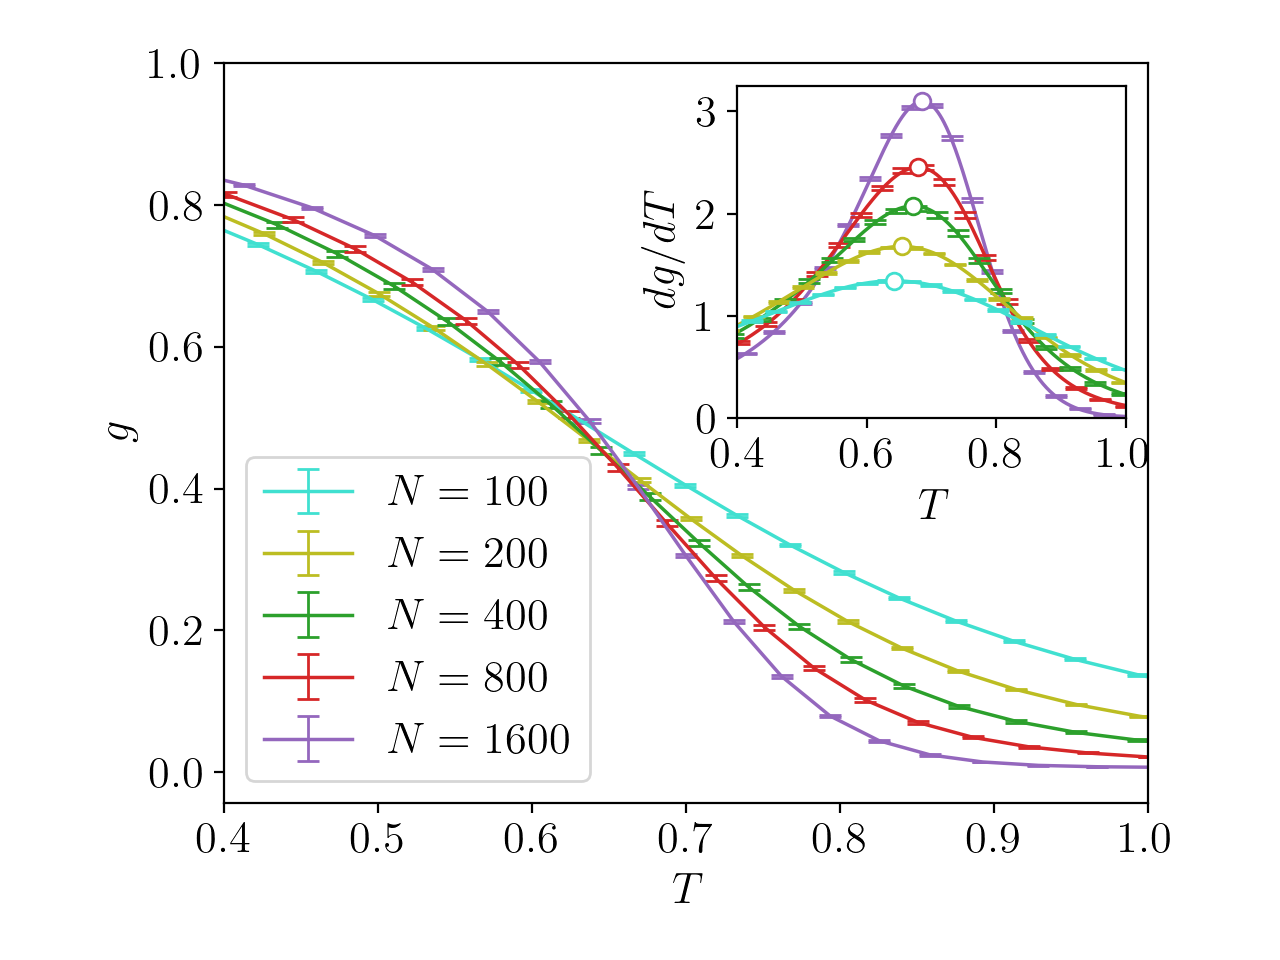

In [25]:
# Set figure parameters
aspect_ratio_g_and_dg_dT = 1
aspect_ratio_fits =  0.8
T0 = T0_Tf_vs_adj[adj_index][0]
Tf = T0_Tf_vs_adj[adj_index][1]

# Plot binder cumulant with errors and pade fits
fig, ax = plt.subplots()
for size_index in range(len(sizes_load)):
    ax.errorbar(T_vs_size_best_load[size_index], g_vs_size_best_load[size_index], yerr=error_vs_size_best_load[size_index], markerfacecolor="None", capsize=4, capthick=1,
                 elinewidth=1,  label=f'$N=\;${sizes_vs_adj_correct_index_load[size_index]}', color=colors_sizes[size_index],linewidth=1.25)
ax.set_xlabel('$T$')
ax.set_ylabel("$g$")



axins = inset_axes(ax, width="42%", height="45%", loc=1)
for size_index in reversed(range(len(sizes_load))):
    axins.errorbar(T_vs_size_best_load[size_index], -dg_dT_vs_size_best_load[size_index], yerr=error_dg_dT_vs_size_best_load[size_index],
                   linewidth=0, markerfacecolor="None", capsize=4, capthick=1,
                 elinewidth=1,  label=f'$N=\;${sizes_vs_adj_correct_index_load[size_index]}', color=colors_sizes[size_index])
    axins.plot(T_pade_load, -dg_dT_pade_array_load[size_index], label=f'$N=${sizes_load[size_index]}', color=colors_sizes[size_index],linewidth=1.25)
    axins.plot(T_max_load[size_index], -dg_dT_pade_T_max_load[size_index], 'o', color=colors_sizes[size_index], markerfacecolor='white',linewidth=1.25)
axins.set_xlabel('$T$')
# axins.set_ylabel("$dg/dT$", loc='top')
axins.set_ylabel("$dg/dT$")


ax.legend(loc='lower left')
ax.set_box_aspect(aspect_ratio_fits)
ax.set_xlim([0.4, 1])
ax.set_ylim(top=1)
axins.set_xlim([0.4, 1])
axins.set_ylim([0,  -dg_dT_pade_T_max_load[-1]*1.05 ])
axins.set_yticks([0, 1, 2, 3])
axins.set_xticks([0.4, 0.6,0.8,1])
fig.tight_layout()
# fig.show()
figs.export(f'g_and_g_pade_and_dg_dT_inset_adj={adjacencies[adj_index]}.pdf')

### [Fig. 3 or 6]

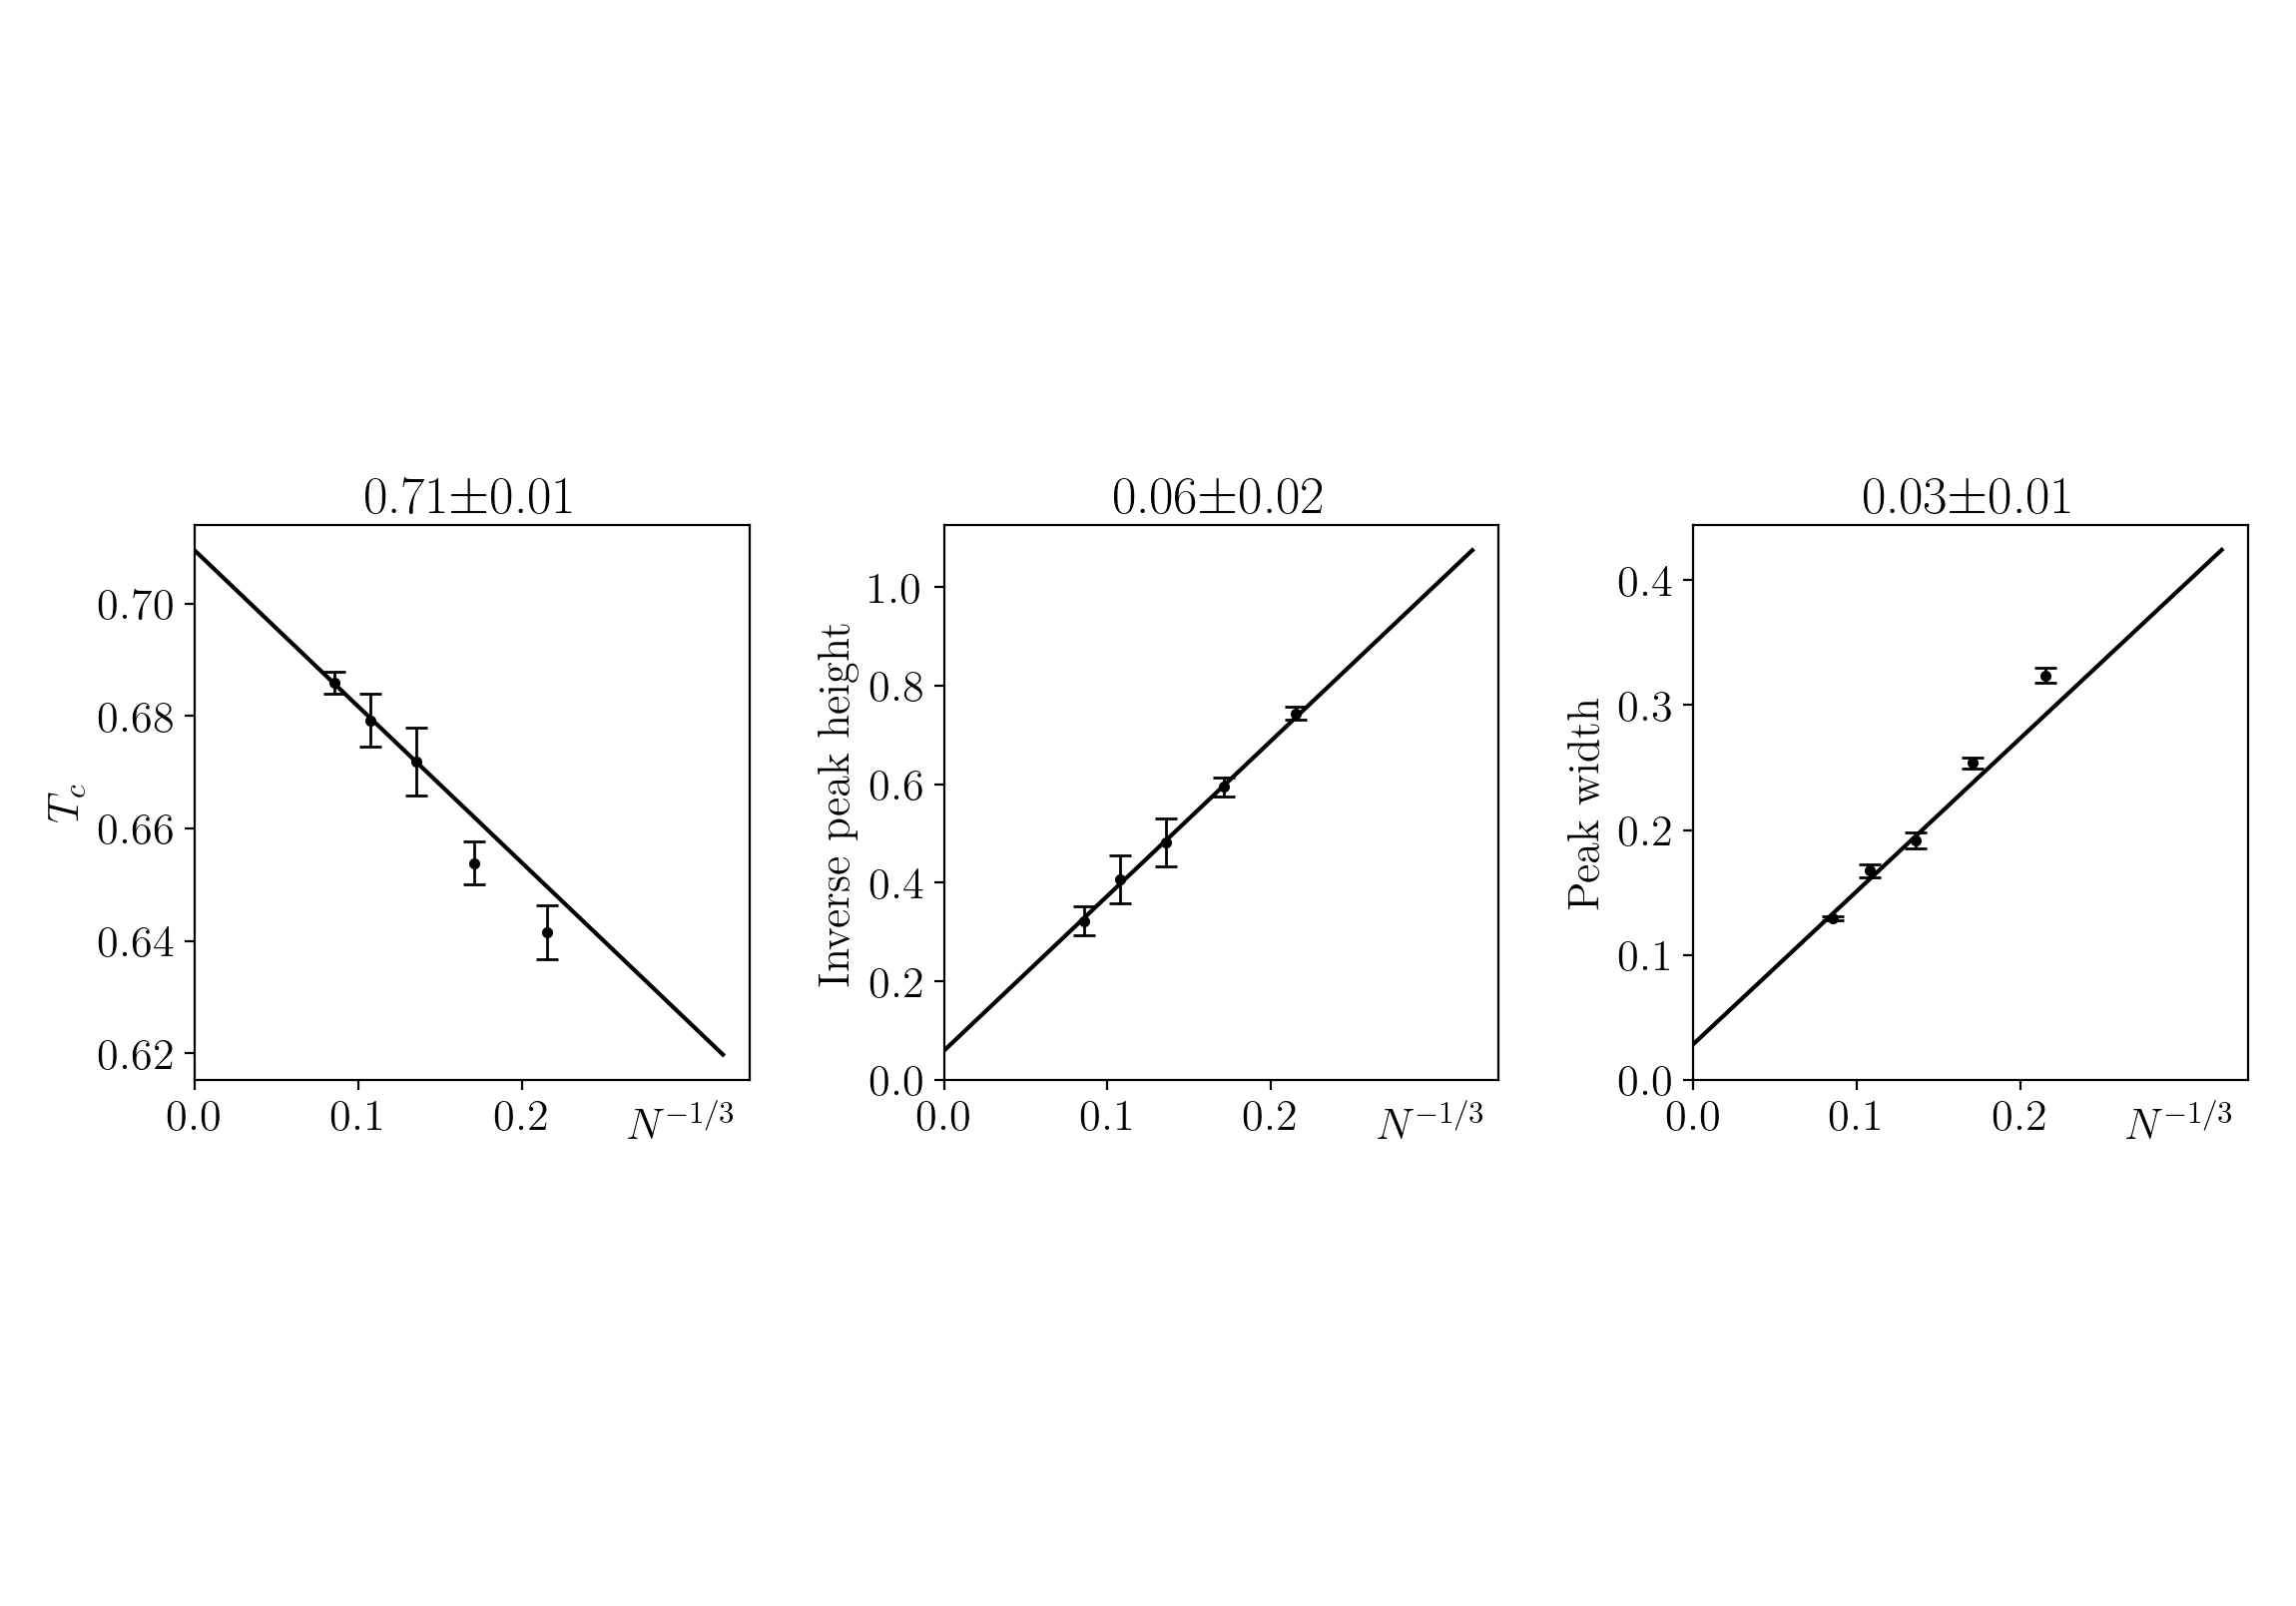

In [26]:
# del sizes_vs_adj[adj_index][4]
figsize_fits = [10*1.15, 7*1.15]
aspect_ratio_fits = 1
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=figsize_fits)
if adjacencies[adj_index] != 'chimera' and adjacencies[adj_index] != 'pegasus' and adjacencies[adj_index] != 'zephyr':

    ax1.plot(x_fit_T_max_load, fit_T_max_array_load, "-", color = 'k')#, label='({:.2f}$\pm${:.1e})'.format(fit_T_max[0],fit_T_max_params[0,0]) +
                                                                            #       '\,$+$\n({:.2f}$\pm${:.2e})'.format(fit_T_max[1],fit_T_max_params[1,1]) + r'$N^{-1/3}$'  )
    ax1.set_xlabel('$N^{-1/3}$')
    ax1.xaxis.set_label_coords(.88, -0.05)
    ax1.set_xticks([0,0.1,0.2])
    ax1.set_xlim(left=0)
    ax1.set_ylabel("$T_c$")
    ax1.set_title('(a)', y=-.3)
    # ax1.legend(fontsize=8)

    ax2.plot(x_fit_T_max_load, fit_1_over_dg_dT_T_max_array_load, "-", color = 'k')
    #, label='({:.2f}$\pm${:.1e})'.format(fit_1_over_dg_dT_T_max[0],fit_1_over_dg_dT_T_max_params[0,0]) +
    # '\,$+$\n({:.2f}$\pm${:.2e})'.format(fit_1_over_dg_dT_T_max[1],fit_1_over_dg_dT_T_max_params[1,1]) + r'$N^{-1/3}$'  )
    ax2.set_xlabel('$N^{-1/3}$')
    ax2.set_ylabel("Inverse peak height")
    # ax2.set_ylabel("$(dg/dT|_{T_c})^{-1}$")
    ax2.xaxis.set_label_coords(.88, -0.05)
    ax2.set_xticks([0,0.1,0.2])
    ax2.set_ylim(bottom=0)
    ax2.set_xlim(left=0)
    ax2.set_title('(b)', y=-.3)
    # ax2.legend(fontsize=8)


    ax3.plot(x_fit_T_max_load, fit_peak_width_array_load, "-", color = 'k')
    #, label='({:.2f}$\pm${:.1e})'.format(fit_peak_width[0],fit_peak_width_params[0,0]) +
    # '\,$+$\n({:.2f}$\pm${:.2e})'.format(fit_peak_width[1],fit_peak_width_params[1,1]) + r'$N^{-1/3}$'  )
    ax3.set_xlabel('$N^{-1/3}$')
    ax3.set_ylabel("Peak width")
    # ax3.set_ylabel("Peak width")
    ax3.xaxis.set_label_coords(.88, -0.05)
    ax3.set_xticks([0,0.1,0.2])
    ax3.set_ylim(bottom=0)
    ax3.set_xlim(left=0)
    ax3.set_title('(c)', y=-.3)
    # ax3.legend(fontsize=8)


    for size_index in range(len(sizes_load)):
        ax1.errorbar(1 / sizes_vs_adj_correct_index_load[size_index] ** (1 / 3), T_max_load[size_index], yerr=Tc_max_err_load[size_index],
                     marker="o", color = 'k', markersize=3, capsize=4, capthick=1,elinewidth=1)

        ax2.errorbar(1 / sizes_vs_adj_correct_index_load[size_index] ** (1 / 3), -1/dg_dT_pade_T_max_load[size_index], yerr=dg_dT_pade_T_max_err_load[size_index],
                     marker="o", color = 'k', markersize=3, capsize=4, capthick=1,elinewidth=1)

        ax3.errorbar(1 / sizes_vs_adj_correct_index_load[size_index] ** (1 / 3), peak_width_load[size_index], yerr=peak_width_err_load[size_index],
                     marker="o", color = 'k', markersize=3, capsize=4, capthick=1,elinewidth=1)

else:
    for size_index in range(len(sizes_load)):
        ax1.errorbar(sizes_vs_adj_correct_index_load[size_index], T_max_load[size_index], yerr=Tc_max_err_load[size_index],
                     marker="o", color = 'k', markersize=3, capsize=4, capthick=1,elinewidth=1, label=sizes_vs_adj[adj_index][size_index])

        ax2.errorbar(sizes_vs_adj_correct_index_load[size_index], dg_dT_pade_T_max_load[size_index], yerr=dg_dT_pade_T_max_err_load[size_index],
                     marker="o", color = 'k', markersize=3, capsize=4, capthick=1,elinewidth=1)

        ax3.errorbar(sizes_vs_adj_correct_index_load[size_index], peak_width_load[size_index], yerr=peak_width_err_load[size_index],
                     marker="o", color= 'k', markersize=3, capsize=4, capthick=1,elinewidth=1)

    ax1.set_xlabel('$N$')
    ax1.set_ylabel("$T_c$")

    # ax2.plot(np.array(sizes_vs_adj[adj_index]),  dg_dT_pade_T_max, "o")
    ax2.set_xlabel('$N$')
    ax2.set_ylabel("Peak height")
    # ax2.set_ylabel("$(dg/dT|_{T_c})$")
    ax2.set_ylim(bottom=-0.1)

    # ax3.plot(np.array(sizes_vs_adj[adj_index]), peak_width, "o")
    ax3.set_xlabel('$N$')
    ax3.set_ylabel("Peak width")
ax1.set_title(f'{Tc_load:.2f}$\pm${Tc_err_load:.2f}')
ax2.set_title(f'{dg_dT_pade_T_max_inf_load:.2f}$\pm${dg_dT_pade_T_max_inf_err_load:.2f}')
ax3.set_title(f'{peak_width_inf_load:.2f}$\pm${peak_width_inf_err_load:.2f}')

ax1.set_box_aspect(aspect_ratio_fits)
ax2.set_box_aspect(aspect_ratio_fits)
ax3.set_box_aspect(aspect_ratio_fits)
fig.tight_layout()
# fig.show()
figs.export(f'Tc_fits={adjacencies[adj_index]}.pdf')

# [Figs. 4 and 7] Tc vs adjacency
## Skip the cell below if you just want to load data

In [32]:
# %% Tc vs adjacency
graphs = 'Dwave' #  'rrg_and_small_world' #
write_file = False
data_type = 'all'
n_bootstrap = 36*10
T_term = 0
ntr = 10
maxfev = 10000

if graphs == 'Dwave':
    adj_iterable = range(len(adjacencies)-3, len(adjacencies))
elif graphs == 'rrg_and_small_world':
    adj_iterable = range(8)

Tc_bootstrap_vs_adj = [[] for _ in range(len(adjacencies))]
Tc_vs_adj = [[] for _ in range(len(adjacencies))]
error_Tc_vs_adj = [[] for _ in range(len(adjacencies))]
T_max_vs_adj = [[] for _ in range(len(adjacencies))]
error_T_max_vs_adj = [[] for _ in range(len(adjacencies))]

if write_file:
    file_simulation_info = open('simulation_info.txt','a')
    file_simulation_info.write('Adjacency & Size & Min. T & Max. T & Tempering copies & MCS & Replicas & Tc \\\\ \n')

for adj_index in adj_iterable:
    sizes = [100, 200, 400, 800, 1200, 1600, 3200]
    sizes_vs_adj = [_ for _ in range(len(adjacencies))]
    for i, adj in enumerate(adjacencies):
        if adj == 'chimera':
            sizes_vs_adj[i] = [72, 200, 392, 800, 1152, 1568, 3200]
        elif adj == 'pegasus':
            sizes_vs_adj[i] = [128, 256, 448, 960, 1288, 1664, 3648]
        elif adj == 'zephyr':
            sizes_vs_adj[i] = [48, 160, 336, 576, 880, 1248, 2736]
        else:
            sizes_vs_adj[i] = sizes

    sizes_vs_adj = [siz_vs_adj[:-1] for siz_vs_adj in sizes_vs_adj]
    sizes = sizes[:-1]

    MCS_avg_vs_size, N_configs_vs_size, copies_vs_size, labels_vs_size, T_vs_size, q2_vs_size, q4_vs_size, \
    ql_vs_size, U_vs_size, U2_vs_size, σ2_q2_bin_vs_size, σ2_q4_bin_vs_size, q_dist_vs_size, g_vs_size, \
    g_bootstrap_vs_size, error_vs_size, dg_dT_vs_size, dg_dT_bootstrap_vs_size, error_dg_dT_vs_size = \
    rfc.read_data(adjacencies[adj_index], distribution, sizes, add_vs_adj[adj_index],
                  T0_Tf_vs_adj[adj_index][0], T0_Tf_vs_adj[adj_index][1], MCS_avg_0,
                  [max_MCSs_vs_adj_binned[adj_index][:-1], max_MCSs_vs_adj_old[adj_index][:-1], max_MCSs_vs_adj_fast[adj_index][:-1]],
                  data_type, only_max_MCS=True)

    n_cases = sum([len(MCS_avg) for MCS_avg in MCS_avg_vs_size])
    results_g_parallel = Parallel(n_jobs=min(cpu_count(), n_cases))(delayed(rfc.binder_cumulant_and_error_bootstrap)
                                                                    (T_vs_size[size_ind][MCS_ind],
                                                                     q2_vs_size[size_ind][MCS_ind],
                                                                     q4_vs_size[size_ind][MCS_ind],
                                                                     n_bootstrap=n_bootstrap, error_type='1')
                                                                    for size_ind in range(len(sizes))
                                                                    for MCS_ind in
                                                                    range(len(MCS_avg_vs_size[size_ind])))

    k = 0
    for size_ind in range(len(sizes)):
        for MCS_ind in range(len(MCS_avg_vs_size[size_ind])):
            g_vs_size[size_ind][MCS_ind], g_bootstrap_vs_size[size_ind][MCS_ind], error_vs_size[size_ind][MCS_ind], \
            dg_dT_vs_size[size_ind][MCS_ind], dg_dT_bootstrap_vs_size[size_ind][MCS_ind], error_dg_dT_vs_size[size_ind][
                MCS_ind] = results_g_parallel[k]
            k += 1
    del results_g_parallel

    T_vs_size_best, g_vs_size_best, error_vs_size_best, dg_dT_vs_size_best, dg_dT_bootstrap_vs_size_best, \
        error_dg_dT_vs_size_best, MCS_avg_vs_size_best, N_configs_vs_size_best  = [[[] for _ in range(len(sizes))] for _ in range(8)]
    dead_index = None

    for size_index in range(len(sizes)):
        assigned = False
        k = -1
        try:
            while not assigned:
                match MCS_N_config_condition:
                    case 'max_MCS_with_minimum_N_configs':
                        if N_configs_vs_size[size_index][k] > min_N_config:
                            assigned = True
                        else:
                            k -= 1
                    case 'max_N_configs':
                        if N_configs_vs_size[size_index][k] == max(N_configs_vs_size[size_index]) and \
                                N_configs_vs_size[size_index][k] > 0:
                            assigned = True
                        else:
                            k -= 1
            print(sizes[size_index], k)
            T_vs_size_best[size_index] = T_vs_size[size_index][k]
            g_vs_size_best[size_index] = g_vs_size[size_index][k]
            error_vs_size_best[size_index] = error_vs_size[size_index][k]
            dg_dT_vs_size_best[size_index] = dg_dT_vs_size[size_index][k]
            dg_dT_bootstrap_vs_size_best[size_index] = dg_dT_bootstrap_vs_size[size_index][k]
            error_dg_dT_vs_size_best[size_index] = error_dg_dT_vs_size[size_index][k]
            MCS_avg_vs_size_best[size_index] = MCS_avg_vs_size[size_index][k]
            N_configs_vs_size_best[size_index] = N_configs_vs_size[size_index][k]
        except:
            dead_index = size_index
            continue

    if dead_index is not None:
        del T_vs_size_best[dead_index], g_vs_size_best[dead_index], error_vs_size_best[dead_index], dg_dT_vs_size_best[dead_index],\
            dg_dT_bootstrap_vs_size_best[dead_index], error_dg_dT_vs_size_best[dead_index], sizes[dead_index], \
            sizes_vs_adj[adj_index][dead_index], MCS_avg_vs_size_best[dead_index], N_configs_vs_size_best[dead_index]

    Tc_bootstrap, T_max_bootstrap = \
        pf.estimate_Tc_with_pade_bootstrap_parallel(sizes_vs_adj[adj_index], T_vs_size_best,
                                                    error_dg_dT_vs_size_best, dg_dT_bootstrap_vs_size_best,
                                                    T_term, ic_jc_vs_adj[adj_index][0], ic_jc_vs_adj[adj_index][1],
                                                    ntr, maxfev, min(n_bootstrap, cpu_count()-1))

    T_max_bootstrap = np.array(T_max_bootstrap).reshape((-1,len(sizes)))
    T_max_bootstrap[T_max_bootstrap==0] = np.nan

    T_max_vs_adj[adj_index] =  np.nanmean(T_max_bootstrap,0)
    error_T_max_vs_adj[adj_index] =  2*np.nanstd(T_max_bootstrap,0)

    Tc_bootstrap_vs_adj[adj_index] = Tc_bootstrap
    Tc_vs_adj[adj_index] = np.nanmean(Tc_bootstrap)
    error_Tc_vs_adj[adj_index] = 2*np.nanstd(Tc_bootstrap)
    # error_Tc_vs_adj.append(np.nanstd(Tc_bootstrap[np.all((Tc - 0.1 < Tc_bootstrap, Tc_bootstrap < Tc + 0.1), 0)]))

    if write_file:
        for size_index in range(len(sizes)):
            add = add_vs_adj[adj_index]
            add_str = f'{add}'
            file_simulation_info.write(f'{adjacencies[adj_index]}{ bool(add>0)*add_str } & {sizes_vs_adj[adj_index][size_index]} & {T0} & {Tf} & '
                                       f'{copies_vs_size[size_index][0]} & {MCS_avg_vs_size_best[size_index]} & {N_configs_vs_size_best[size_index]}  \\\\ \n')

if write_file:
    file_simulation_info.close()

sizes = sizes_vs_adj[adj_index]

chimera
Old data
Binned data
Fast data
100 40000 16911
1600 320000 2724
200 40000 12026
800 160000 5587
400 80000 11476
400 1280000 951
200 640000 1987
800 2560000 2672
100 320000 5012
400 640000 11123
1200 2560000 2058
800 1280000 5071
1600 5120000 2508
100 -1
200 -1
400 -2
800 -1
1200 -1
1600 -1


/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value enc

pegasus
Old data
Binned data
Fast data
400 80000 10327
1600 320000 2380
100 40000 9641
800 160000 4514
200 40000 9052
200 640000 230
400 1280000 539
100 320000 1950
800 2560000 1652
200 80000 10408
100 80000 16077
1600 5120000 2192
800 1280000 3971
1200 2560000 1836
400 640000 22395
100 -1
200 -4
400 -2
800 -1
1200 -1
1600 -1


/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value enc

zephyr
Old data
Binned data
Fast data
200 640000 740
400 1280000 659
100 320000 5020
800 2560000 3057
200 80000 9704
100 80000 15952
400 640000 5516
800 1280000 4008
1600 5120000 2448
1200 2560000 5943
100 -1
200 -4
400 -2
800 -1
1200 -1
1600 -1


/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value encountered in sqrt
  var = np.sqrt(np.sum(xchi ** 2) / ntr - mu ** 2)
/home/gabriel/onedrive/2021/Avaqus/Architecture_v1/Modules/pade_fits.py:162: RuntimeWarning: invalid value enc

In [36]:
error_T_max_vs_adj

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 array([0.0129074 , 0.02040848, 0.00761681, 0.01889209, 0.0177054 ,
        0.01344799]),
 array([0.62916243, 0.0139741 , 0.00987997, 0.02727574, 0.32955765,
        0.02147151]),
 array([0.02423798, 0.01600934, 0.02070558, 0.03044696, 0.01936143,
        0.03231498])]

In [33]:
# Store calculated data
fname = f'Processed_Data/Tc_vs_adj_{graphs}_read_mode={MCS_N_config_condition}_min_N_config={min_N_config}'
np.savez(fname, sizes=sizes, sizes_vs_adj=sizes_vs_adj, Tc_vs_adj=Tc_vs_adj, error_Tc_vs_adj=error_Tc_vs_adj, T_max_vs_adj=T_max_vs_adj,
         error_T_max_vs_adj=error_T_max_vs_adj,  allow_pickle=True)

## Run the cell below if you just want to load data

In [4]:
# Load calculated data
graphs = 'Dwave'
# graphs = 'rrg_and_small_world'
fname = f'Processed_Data/Tc_vs_adj_{graphs}_read_mode={MCS_N_config_condition}_min_N_config={min_N_config}.npz'
data = np.load(fname, allow_pickle=True)
sizes_load = data['sizes']
sizes_vs_adj_load = data['sizes_vs_adj']
Tc_vs_adj_load = data['Tc_vs_adj']
error_Tc_vs_adj_load = data['error_Tc_vs_adj']
T_max_vs_adj_load = data['T_max_vs_adj']
error_T_max_vs_adj_load = data['error_T_max_vs_adj']

## [Fig. 4] rrg and small_world vs theory

C:\Users\gabri\AppData\Local\Temp\ipykernel_2040\1116553086.py:9: RuntimeWarning: divide by zero encountered in divide
  y = np.tanh(x / Tc) ** 2 * np.exp(-0.5 * (x ** 2)) / np.sqrt(2 * np.pi)


[0.7479748  1.52355236 2.05640564 2.48574857]


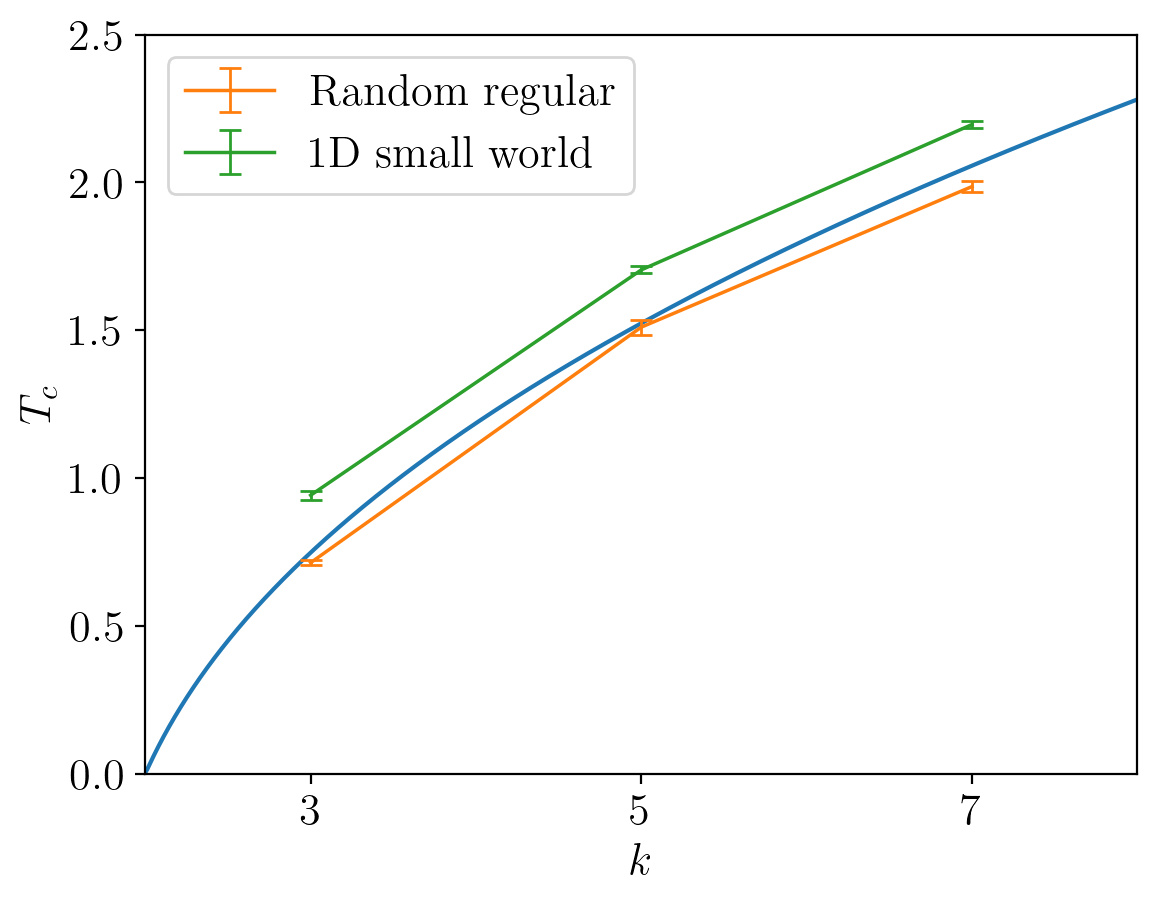

In [14]:
# %% RRG and 1D vs theory
Tc_x = np.linspace(0, 3, 10000)
x = np.linspace(-100, 100, 10000)
k = np.zeros([len(Tc_x)])
mu = 0
std = 0.93
for i, Tc in enumerate(Tc_x):
    # y = np.tanh(x / Tc) ** 2 * np.exp(-0.5 * ((x - mu) / std) ** 2) / (np.sqrt(2 * np.pi) * std)
    y = np.tanh(x / Tc) ** 2 * np.exp(-0.5 * (x ** 2)) / np.sqrt(2 * np.pi)
    k[i] = 1 / np.trapz(y, x)

fig, ax = plt.subplots(dpi=200)
ax.plot(k + 1, Tc_x)
# ax.errorbar([5, 7], [Tc_bootstrap.mean(), 1.99], [Tc_bootstrap.std(), 0.02])
ax.errorbar(np.array([3, 5, 7]), Tc_vs_adj_load[:3], error_Tc_vs_adj_load[:3], label='Random regular', markerfacecolor="None", capsize=4, capthick=1,
                 elinewidth=1, linewidth=1.25)
ax.errorbar(np.array([3, 5, 7]), Tc_vs_adj_load[4:-5], error_Tc_vs_adj_load[4:-5], label='1D small world', markerfacecolor="None", capsize=4, capthick=1,
                 elinewidth=1, linewidth=1.25)

ax.set_xticks([3, 5, 7])
ks = [np.abs(k+1-ki).argmin() for ki in [3, 5, 7, 9]]
print(Tc_x[ks])

ax.set_xlim([2,8])
ax.set_ylim([0,2.5])
ax.legend()
ax.set_xlabel('$k$')
ax.set_ylabel('$T_c$')
figs.export(f'Random-regular and small-world vs theory.pdf')

# [Fig. 7] Tc vs adjacency: D-Wave
## Start here if you just want to load data

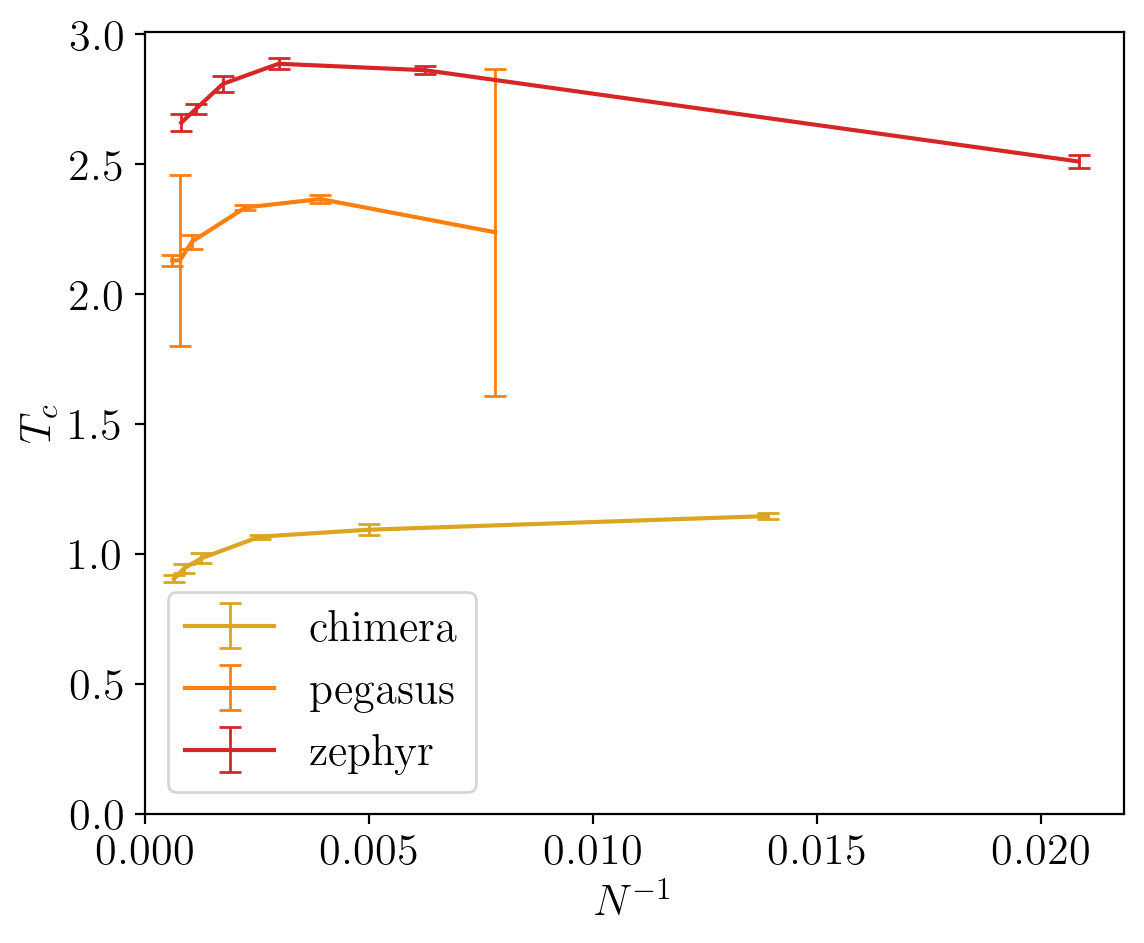

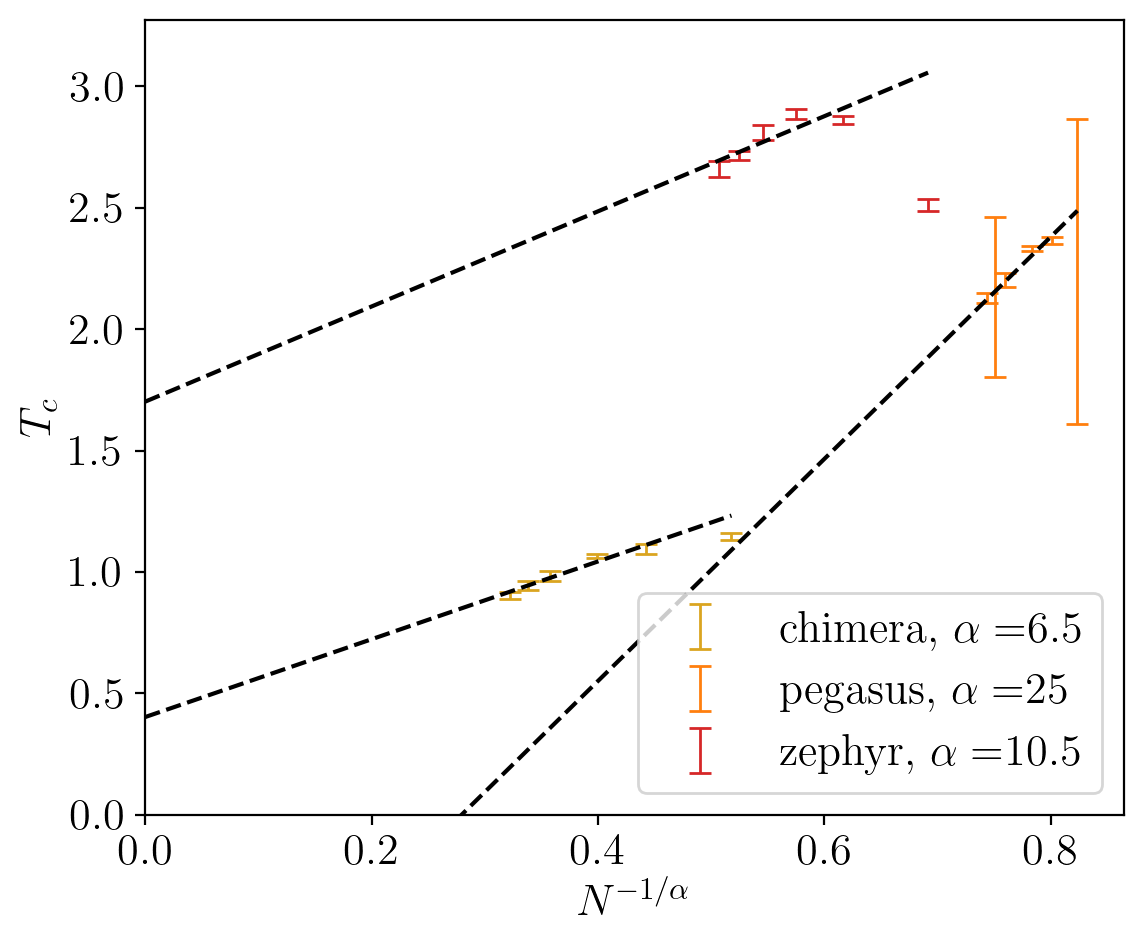

In [6]:
alpha_vs_adj = [_ for _ in range(len(adjacencies))]
alpha_vs_adj[-3] = 6.5
alpha_vs_adj[-2] = 25
alpha_vs_adj[-1] = 10.5

color_vs_adj = [ 'turquoise',  'tab:olive', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray','tab:blue', 'goldenrod', 'tab:orange', 'tab:red']

fig, ax1 = plt.subplots(figsize=[6,5])
fig2, ax2 = plt.subplots(figsize=[6,5])

for adj_index in range(len(adjacencies)-3, len(adjacencies)):
    ax1.errorbar(1/np.array(sizes_vs_adj_load[adj_index]), T_max_vs_adj_load[adj_index], yerr=error_T_max_vs_adj_load[adj_index], label=rf'{adjacencies[adj_index]}',
                color=color_vs_adj[adj_index], markersize=3, capsize=4, capthick=1,elinewidth=1)

    alpha = alpha_vs_adj[adj_index]
    x_fit_T_max = np.linspace(0, 1/sizes_vs_adj_load[adj_index][0]**(1/alpha), 100)
    z = np.polyfit(1/np.array(sizes_vs_adj_load[adj_index][1:])**(1/alpha), T_max_vs_adj_load[adj_index][1:],1)
    fit_T_max = np.poly1d(z)

    ax2.errorbar(1/np.array(sizes_vs_adj_load[adj_index])**(1/alpha), T_max_vs_adj_load[adj_index], yerr=error_T_max_vs_adj_load[adj_index], label=rf'{adjacencies[adj_index]}, $\alpha=${alpha}',
                color=color_vs_adj[adj_index], markersize=3, capsize=4, capthick=1,elinewidth=1, linewidth=0)
    ax2.plot(x_fit_T_max,fit_T_max(x_fit_T_max), color='k',linestyle='--')
    # ax.errorbar(np.array(sizes_vs_adj[adj_index]), T_max_vs_adj[adj_index], yerr=error_T_max_vs_adj[adj_index], label=f'{adjacencies[adj_index]}')

ax1.legend()
ax1.set_ylabel('$T_c$')
ax1.set_xlabel(r'$N^{-1}$')
ax1.set_ylim(bottom=0)
ax1.set_xlim(left=0)
ax2.legend()
ax2.set_ylabel('$T_c$')
ax2.set_xlabel(r'$N^{-1/\alpha}$')
ax2.set_ylim(bottom=0)
ax2.set_xlim(left=0)
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_title(rf'$\alpha=${alpha}')
fig.tight_layout()
fig2.tight_layout()

figs.export(f'Tc_vs_adjacency_Dwave.pdf')

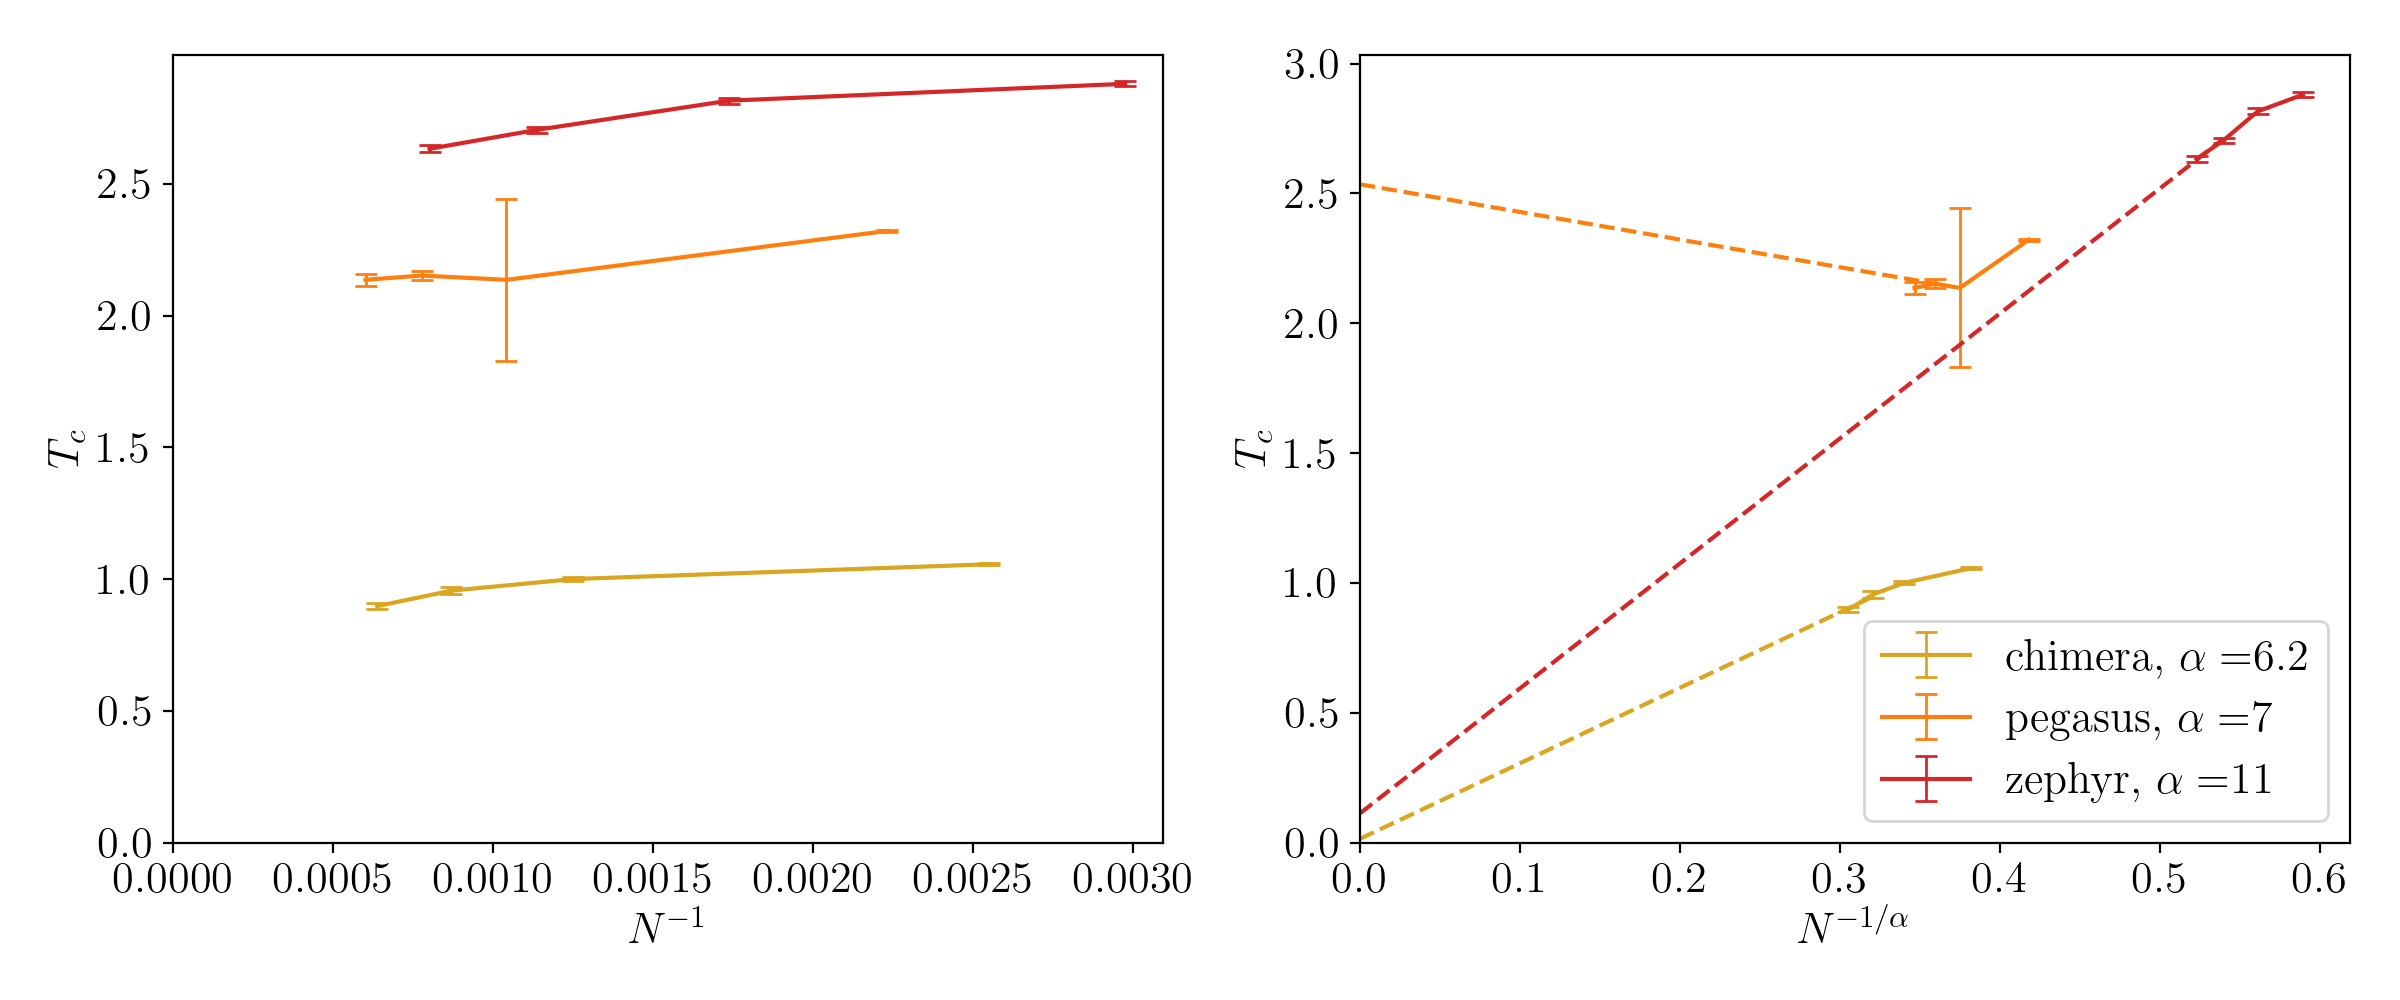

In [5]:
alpha_vs_adj = [_ for _ in range(len(adjacencies))]
alpha_vs_adj[-3] = 6.2
alpha_vs_adj[-2] = 7
alpha_vs_adj[-1] = 11

color_vs_adj = [ 'turquoise',  'tab:olive', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray','tab:blue', 'goldenrod', 'tab:orange', 'tab:red']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=[12,5])

for adj_index in range(len(adjacencies)-3, len(adjacencies)):
    ax1.errorbar(1/np.array(sizes_vs_adj[adj_index]), T_max_vs_adj[adj_index], yerr=error_T_max_vs_adj[adj_index], label=rf'{adjacencies[adj_index]}',
                color=color_vs_adj[adj_index], markersize=3, capsize=4, capthick=1,elinewidth=1)

    alpha = alpha_vs_adj[adj_index]
    x_fit_T_max = np.linspace(0, 1/sizes_vs_adj[adj_index][2]**(1/alpha), 100)
    if adjacencies[adj_index] == 'pegasus':
        z = np.polyfit(1/np.array(sizes_vs_adj[adj_index][1:-1])**(1/alpha), T_max_vs_adj[adj_index][1:-1],1)
    else:
        z = np.polyfit(1/np.array(sizes_vs_adj[adj_index][1:])**(1/alpha), T_max_vs_adj[adj_index][1:],1)
    fit_T_max = np.poly1d(z)
    ax2.plot(x_fit_T_max,fit_T_max(x_fit_T_max), color=color_vs_adj[adj_index],linestyle='--' )
    ax2.errorbar(1/np.array(sizes_vs_adj[adj_index])**(1/alpha), T_max_vs_adj[adj_index], yerr=error_T_max_vs_adj[adj_index], label=rf'{adjacencies[adj_index]}, $\alpha=${alpha}',
                color=color_vs_adj[adj_index], markersize=3, capsize=4, capthick=1,elinewidth=1)
    # ax.errorbar(np.array(sizes_vs_adj[adj_index]), T_max_vs_adj[adj_index], yerr=error_T_max_vs_adj[adj_index], label=f'{adjacencies[adj_index]}')

ax1.set_ylabel('$T_c$')
ax1.set_xlabel(r'$N^{-1}$')
ax1.set_ylim(bottom=0)
ax1.set_xlim(left=0)

ax2.legend()
ax2.set_ylabel('$T_c$')
ax2.set_xlabel(r'$N^{-1/\alpha}$')
ax2.set_ylim(bottom=0)
ax2.set_xlim(left=0)

fig.tight_layout()

figs.export(f'Tc_vs_adj.pdf')

# [Fig. 8] Autocorrelation times

In [48]:
# Read autocorrelation time data vs adjacency
T_vs_adj = [[] for _ in range(len(adjacencies))]
tau_q2_T_vs_adj = [[] for _ in range(len(adjacencies))]
σ2_q2_bin_vs_adj = [[] for _ in range(len(adjacencies))]
adj_indices = adj_indices = adj_indices = [0, 9, 10, 11]

for adj_index in adj_indices:
    _, _, _, _, T_vs_adj[adj_index], _, _, _, _, _, σ2_q2_bin_vs_adj[adj_index] = \
        rfc.read_data(adjacencies[adj_index], distribution, sizes, add_vs_adj[adj_index], T0_Tf_vs_adj[adj_index][0],
        T0_Tf_vs_adj[adj_index][1], MCS_avg_0, [max_MCSs_vs_adj_binned[adj_index][:-1], _, _], data_type='binned')[:11]
    del T_vs_adj[adj_index][4], σ2_q2_bin_vs_adj[adj_index][4], sizes_vs_adj[adj_index][4]
del sizes[4]

random_regular_3
Binned data
zephyr
Binned data


In [6]:
# Calculate autocorrelation time
for adj_index in adj_indices:
    tau_q2_T_vs_adj[adj_index] = rfc.autocorrelation_time_q2(σ2_q2_bin_vs_adj[adj_index])

In [7]:
# Store calculated data
fname = f'Processed_Data/Autocorrelation_times_adjacencies={adj_indices}'
np.savez(fname, sizes=sizes, sizes_vs_adj=sizes_vs_adj, T_vs_adj=T_vs_adj, tau_q2_T_vs_adj=tau_q2_T_vs_adj,  allow_pickle=True)

/home/gabriel/anaconda3/envs/Architecture_v1/lib/python3.10/site-packages/numpy/lib/npyio.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


## [Fig. 8] Autocorrelation times
## Start here if you just want to load data

In [51]:
# Load calculated data
adj_indices = adj_indices = adj_indices = [0, 9, 10, 11]

fname = f'Processed_Data/Autocorrelation_times_adjacencies={adj_indices}.npz'
data = np.load(fname, allow_pickle=True)
sizes_load = data['sizes']
sizes_vs_adj_load = data['sizes_vs_adj']
T_vs_adj_load = data['T_vs_adj']
tau_q2_T_vs_adj_load = data['tau_q2_T_vs_adj']

In [52]:
# Calculate autocorrelation time fits
T_fit_tau_vs_adj, log_tau_fit_vs_adj, log_tau_vs_adj, T_tau_vs_adj = [ [[[] for _ in range(len(sizes))] for _ in range(len(adjacencies))] for _ in range(4)]
divide_by_size = True

for adj_index in adj_indices:
    for size_index in range(len(sizes_load)):
        fit_start_index = np.where(np.isfinite(tau_q2_T_vs_adj_load[adj_index][size_index]))[0][0]

        T = T_vs_adj_load[adj_index][size_index][-1][fit_start_index:]
        T_tau_vs_adj[adj_index][size_index] = T

        if divide_by_size:
            tau = tau_q2_T_vs_adj_load[adj_index][size_index][fit_start_index:]/sizes_vs_adj_load[adj_index][size_index]
        else:
            tau = tau_q2_T_vs_adj_load[adj_index][size_index][fit_start_index:]

        log_tau_vs_adj[adj_index][size_index] = np.log10(tau)

        T_fit_tau_vs_adj[adj_index][size_index] = np.linspace(T[0], T[-1], 1000)
        log_tau_fit_vs_adj[adj_index][size_index] = np.poly1d(np.polyfit(T, log_tau_vs_adj[adj_index][size_index], 10))(T_fit_tau_vs_adj[adj_index][size_index])

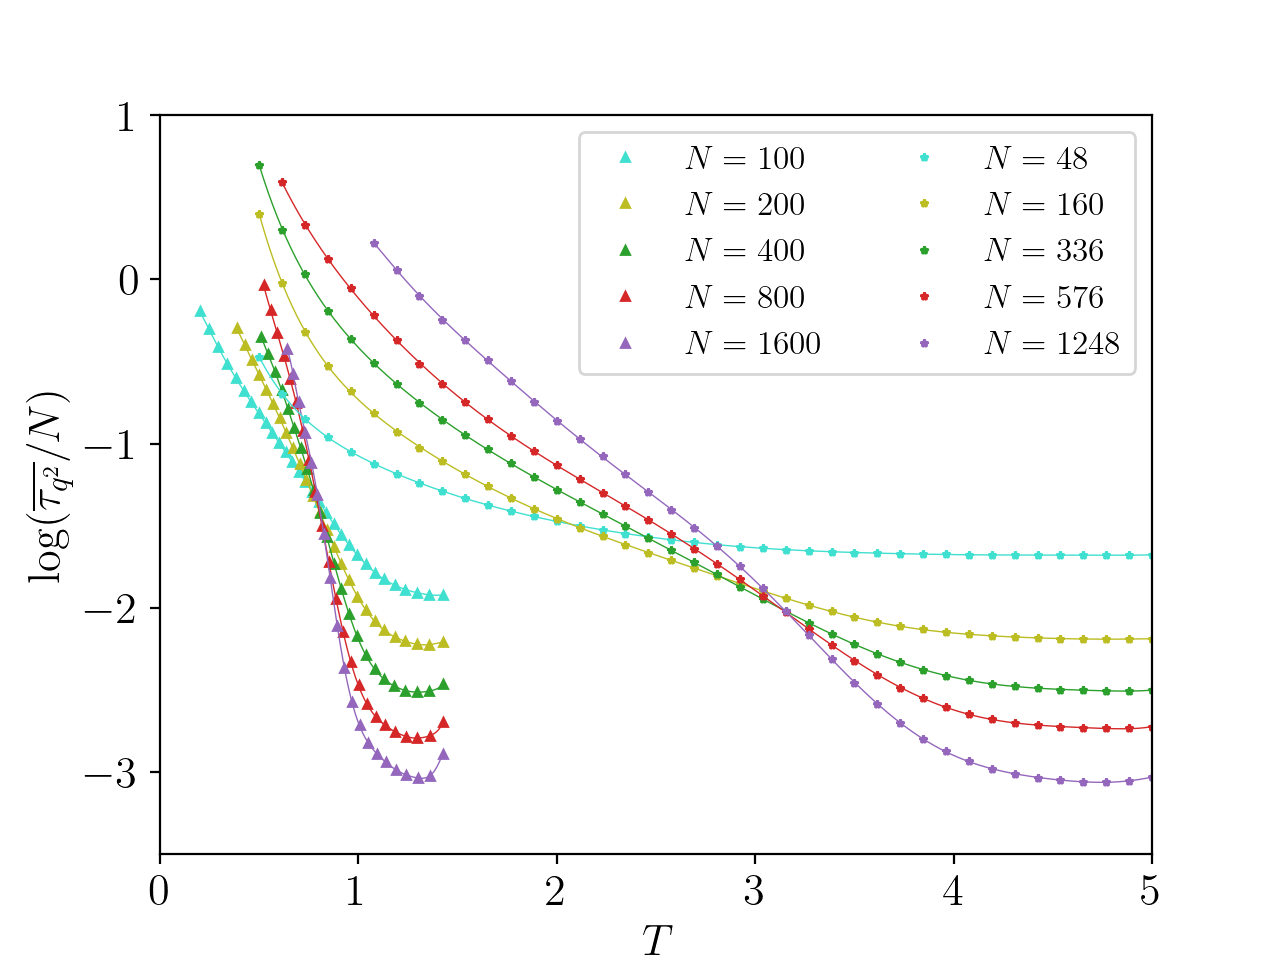

In [61]:
#Plot autocorrelation time
fig, ax = plt.subplots()
for adj_index in adj_indices:
    for size_index in range(len(sizes)):

        ax.plot(T_tau_vs_adj[adj_index][size_index], log_tau_vs_adj[adj_index][size_index],
                color=colors_sizes[size_index], marker=marker_adjacencies[adj_index], linewidth=0, markersize=3, label=f'$N=\;${sizes_vs_adj[adj_index][size_index]}')
        ax.plot(T_fit_tau_vs_adj[adj_index][size_index], log_tau_fit_vs_adj[adj_index][size_index], color=colors_sizes[size_index], linewidth=0.5)

    # ax.set_title(adjacencies[adj_index])
    ax.set_xlabel('$T$')

    if divide_by_size:
        ax.set_ylim([-3.5, 1])
        ax.set_xlim([0, 5])
    else:
        ax.set_ylim([-0.1, 3.5])
        ax.set_xlim([0, 5])

if divide_by_size:
    ax.set_ylabel(r'$\log(\overline{\tau_{q^2}}/N)$')
else:
    ax.set_ylabel(r'$\log(\overline{\tau_{q^2}})$')


ax.legend(fontsize=12, ncol=2)
figs.export(f'Autocorrelation_time_rrg_3_vs_zephyr.pdf')

## [Inset Fig. 8] Autocorrelation times scaling
## Start here if you just want to load data

In [8]:
# Load calculated data
adj_indices = adj_indices = [0, 9, 10, 11]
fname = f'Processed_Data/Autocorrelation_times_adjacencies={adj_indices}.npz'
data = np.load(fname, allow_pickle=True)
sizes_load = data['sizes']
sizes_vs_adj_load = data['sizes_vs_adj']
T_vs_adj_load = data['T_vs_adj']
tau_q2_T_vs_adj_load = data['tau_q2_T_vs_adj']

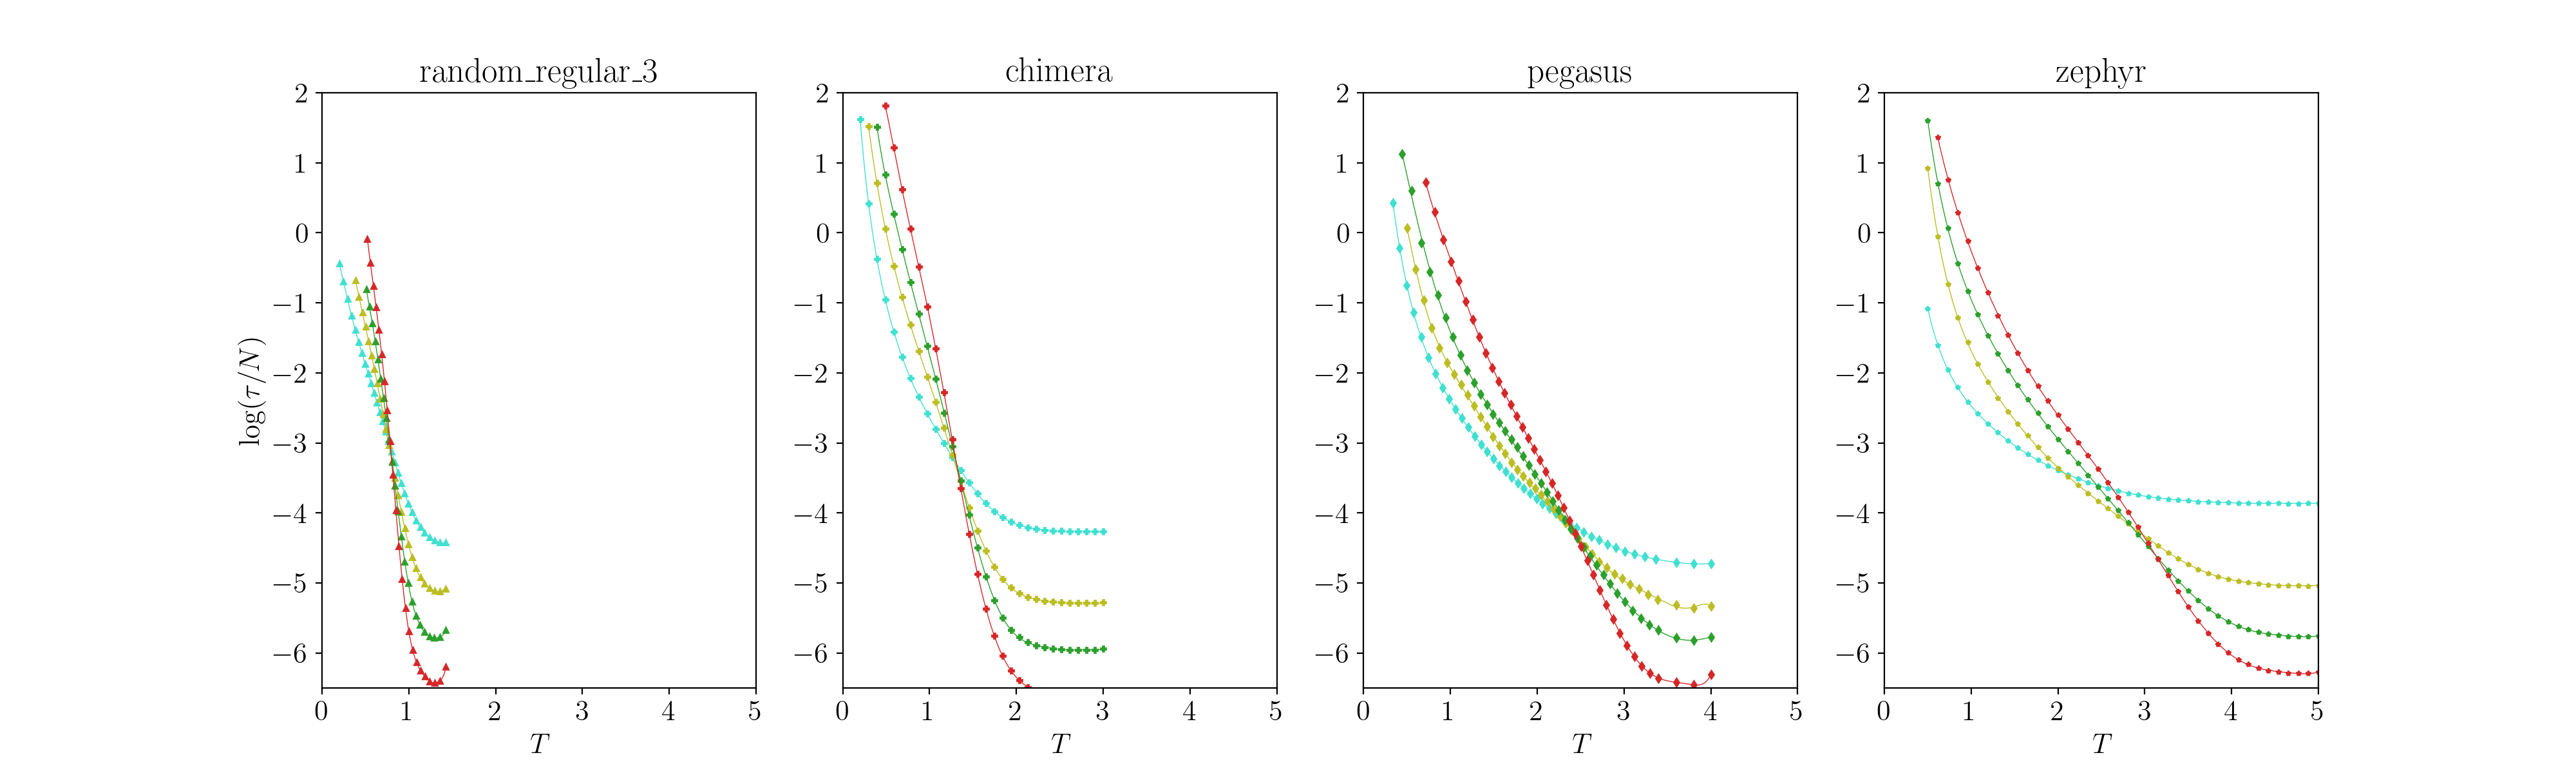

In [16]:
# %% BINNED DATA ONLY Calculate autocorrelation time fits
T_fit_tau_vs_adj, log_tau_fit_vs_adj, log_tau_vs_adj, T_tau_vs_adj = [ [[[] for _ in range(len(sizes))] for _ in range(len(adjacencies))] for _ in range(4)]
divide_by_size = True

for adj_index in adj_indices:
    for size_index in range(len(sizes)):
        fit_start_index = np.where(np.isfinite(tau_q2_T_vs_adj[adj_index][size_index]))[0][0]

        T = T_vs_adj[adj_index][size_index][-1][fit_start_index:]
        T_tau_vs_adj[adj_index][size_index] = T

        if divide_by_size:
            tau = tau_q2_T_vs_adj[adj_index][size_index][fit_start_index:]/sizes_vs_adj[adj_index][size_index]
        else:
            tau = tau_q2_T_vs_adj[adj_index][size_index][fit_start_index:]

        log_tau_vs_adj[adj_index][size_index] = np.log(tau)

        T_fit_tau_vs_adj[adj_index][size_index] = np.linspace(T[0], T[-1], 1000)
        log_tau_fit_vs_adj[adj_index][size_index] = np.poly1d(np.polyfit(T, log_tau_vs_adj[adj_index][size_index], 10))(T_fit_tau_vs_adj[adj_index][size_index])

# %% BINNED DATA ONLY Plot autocorrelation time
fig, ax = plt.subplots(ncols=4, figsize=[20, 6])
for i, adj_index in enumerate(adj_indices):
    for size_index in range(len(sizes)):
        ax[i].plot(T_tau_vs_adj[adj_index][size_index], log_tau_vs_adj[adj_index][size_index],
                color=colors_sizes[size_index], marker=marker_adjacencies[adj_index], linewidth=0, markersize=3)
        ax[i].plot(T_fit_tau_vs_adj[adj_index][size_index], log_tau_fit_vs_adj[adj_index][size_index], color=colors_sizes[size_index], linewidth=0.5)

    ax[i].set_title(adjacencies[adj_index])
    ax[i].set_xlabel('$T$')

    if divide_by_size:
        ax[i].set_ylim([-6.5, 2])
        ax[i].set_xlim([0, 5])
    else:
        ax[i].set_ylim([-0.1, 3.5])
        ax[i].set_xlim([0, 5])

if divide_by_size:
    ax[0].set_ylabel(r'$\log(\tau/N)$')
else:
    ax[0].set_ylabel(r'$\log(\tau)$')


In [ ]:
# %% BINNED DATA ONLY Calculate autocorrelation time vs size for different temperatures
Ts = np.linspace(0.5, 5, 10)
log_tau_vs_size_for_specific_T_vs_adj = [[[] for _ in range(len(Ts))] for _ in range(len(adjacencies))]

for adj_index in adj_indices:
    for size_index in range(len(sizes)):
        for T_fit_index, T in enumerate(Ts):
            if np.any(np.abs(T_fit_tau_vs_adj[adj_index][size_index]-T) < 0.1):
                T_index = np.where(np.abs(T_fit_tau_vs_adj[adj_index][size_index]-T) == np.abs(T_fit_tau_vs_adj[adj_index][size_index]-T).min())[0][0]
                log_tau_vs_size_for_specific_T_vs_adj[adj_index][T_fit_index].append(log_tau_fit_vs_adj[adj_index][size_index][T_index])
            else:
                log_tau_vs_size_for_specific_T_vs_adj[adj_index][T_fit_index].append(np.nan)

# %% Define scaling law for tau(T) vs N
def scaling_law_manuel(x,a,b, c):
     # scaling law for log(tau) = f(log(N))
     # This corresponds to tau = N^a * e^(bN)
    # return a*x + 0*b*np.exp(c*x) + c
    return 0*a*x + b*np.exp(c*x)

def scaling_law(x, a, b):
    return a**x*np.exp(b*x)

# %% BINNED DATA ONLY Plot autocorrelation time vs size for different temperatures
fit_params_log_tau_vs_size_for_specific_T_vs_adj = [[[] for _ in range(len(Ts))] for _ in range(len(adjacencies))]

colors_autocorrelation = plt.get_cmap('plasma')(np.linspace(0, 255, len(Ts)).astype('int'))
fig, ax = plt.subplots(ncols=4, figsize=[26, 6])

for i, adj_index in enumerate(adj_indices):
    for T_fit_index, T in enumerate(Ts):

        log_tau_vs_size = log_tau_vs_size_for_specific_T_vs_adj[adj_index][T_fit_index]
        # Print in log log
        ax[i].plot(np.log(sizes_vs_adj[adj_index]), log_tau_vs_size, color=colors_autocorrelation[T_fit_index], linewidth=0, marker=marker_adjacencies[adj_index], markersize=3)
        # Print in linear
        # ax[i].plot(sizes_vs_adj[adj_index], np.exp(log_tau_vs_size), color=colors_autocorrelation[T_fit_index], linewidth=0, marker=marker_adjacencies[adj_index], markersize=3)
        try:
            non_thermalized_index = np.where(~np.isnan(log_tau_vs_size))[0][-1]

            # log(tau) = A + B*log(N)
            # params = np.polyfit(np.log(sizes_vs_adj[adj_index][:non_thermalized_index+1]), log_tau_vs_size[:non_thermalized_index+1], 1)
            # N0 = np.log(sizes_vs_adj[adj_index][:non_thermalized_index+1])[0]
            # Nf = np.log(sizes_vs_adj[adj_index][:non_thermalized_index+1])[-1]
            # sizes_fit = np.linspace(N0, Nf, 100)
            # ax[i].plot(sizes_fit, np.poly1d(params)(sizes_fit), color=colors_autocorrelation[T_fit_index], linewidth=1)

            # scaling law manuel
            params = curve_fit(scaling_law_manuel, np.log(sizes_vs_adj[adj_index][:non_thermalized_index+1]), log_tau_vs_size[:non_thermalized_index+1])[0]
            N0 = np.log(sizes_vs_adj[adj_index][:non_thermalized_index+1])[0]
            Nf = np.log(sizes_vs_adj[adj_index][:non_thermalized_index+1])[-1]
            sizes_fit = np.linspace(N0, Nf, 100)
            ax[i].plot(sizes_fit, scaling_law_manuel(sizes_fit, *params), color=colors_autocorrelation[T_fit_index], linewidth=1)

            #
            # params = curve_fit(scaling_law, sizes_vs_adj[adj_index][:non_thermalized_index+1], np.exp(log_tau_vs_size[:non_thermalized_index+1]))[0]
            # N0 = sizes_vs_adj[adj_index][:non_thermalized_index+1][0]
            # Nf = sizes_vs_adj[adj_index][:non_thermalized_index+1][-1]
            # sizes_fit = np.linspace(N0, Nf, 100)
            # ax[i].plot(np.log(sizes_fit), np.log(scaling_law(sizes_fit, *params)), color=colors_autocorrelation[T_fit_index], linewidth=1)

            fit_params_log_tau_vs_size_for_specific_T_vs_adj[adj_index][T_fit_index] = params.copy()
        except:
            fit_params_log_tau_vs_size_for_specific_T_vs_adj[adj_index][T_fit_index] = np.zeros([len(fit_params_log_tau_vs_size_for_specific_T_vs_adj[adj_index][T_fit_index-1])])

    ax[i].set_title(adjacencies[adj_index])
    ax[i].set_xlabel(r'$\log(N)$')
    # ax[i].set_yscale('log', base=10)
    # ax[i].set_ylim([-0.1, 3.5])
    # ax[i]. set_xlim([4e1,2e3])
    # ax[i].set_xscale('log', base=10)

if divide_by_size:
    ax[0].set_ylabel(r'$\log(\tau/N)$')
else:
    ax[0].set_ylabel(r'$\log(\tau)$')
# fig.suptitle(f'$\\alpha={alpha}$')
figs.colorbar_for_lines(fig, Ts[::2].round(1))
fig.show()

# %% BINNED DATA ONLY Plot fit params of autocorrelation time vs size
fig, ax = plt.subplots()

for i, adj_index in enumerate(adj_indices):
    params = np.array(fit_params_log_tau_vs_size_for_specific_T_vs_adj[adj_index])
    params[params == 0] = np.nan
    ax.plot(Ts, params[:, 0], marker=marker_adjacencies[adj_index], markersize=4, linewidth=1, color='b', label=f'A(T), {adjacencies[adj_index]}')
    ax.plot(Ts, params[:, 1], marker=marker_adjacencies[adj_index], markersize=4, linewidth=1, color='r', label=f'B(T), {adjacencies[adj_index]}')
    # ax.plot(Ts, 10**(params[:, 1]), marker = marker_adjacencies[adj_index])

ax.legend(fontsize=8, ncols=3)
fig.suptitle(r'$ \tau(N) \propto N^{A(T)}e^{B(T)N}$')
ax.set_yscale('log')
ax.set_ylabel(r'$A(T),B(T)$')
ax.set_xlabel(r'$T$')
fig.show()